# SURE 2024 Speedy Simulations Kickoff
## Kernel Density Estimation with Quasi-Monte Carlo Methods

This demo makes use of our QMCPy software package.  See [qmcpy.org](www.qmcpy.org) for more details.

### If you are running this on colab, run this cell, otherwise you can ignore it and go to the next one.

In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
!sudo apt install cm-super
# !pip install qmcpy

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern
  pfb2t1c2pfb poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  tex-common tex-gyre texlive-base texlive-binaries texlive-fonts-recommended
  texlive-latex-base texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x
  libavalon-fram

In [ ]:
!pip install git+https://github.com/QMCSoftware/QMCSoftware.git@SURE2024

  Cloning https://github.com/QMCSoftware/QMCSoftware.git (to revision SURE2024) to /tmp/pip-req-build-qu4nsx7o
  Running command git clone --filter=blob:none --quiet https://github.com/QMCSoftware/QMCSoftware.git /tmp/pip-req-build-qu4nsx7o
  Running command git checkout -b SURE2024 --track origin/SURE2024
  Switched to a new branch 'SURE2024'
  Branch 'SURE2024' set up to track remote branch 'SURE2024' from 'origin'.
  Resolved https://github.com/QMCSoftware/QMCSoftware.git to commit 263ce4c43913e01da3590d8e86d8114e75c3b135
  Preparing metadata (setup.py) ... done
  Created wheel for qmcpy: filename=qmcpy-1.4.5-cp310-cp310-linux_x86_64.whl size=7699174 sha256=c9ad6028c4278a30d7aa7eaba47f4283f35e521a25be9066fb7c3ab93e9904e5
  Stored in directory: /tmp/pip-ephem-wheel-cache-3millosr/wheels/61/a5/53/fa99d8a2ca1c19bfbc4564f3fb3b61750c00a279c0a1bd6972
Successfully built qmcpy


### Import needed packages

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import qmcpy as qp
from scipy import stats
from copy import deepcopy
import sympy as sy
import sympy.stats
figpath = '' #this path sends the figures to the directory that you want
savefigs = True
imgfrmt = 'pdf' #kind of format to save figures as

### Some LaTeX macros (hidden in math mode)
$
\newcommand{\vt}{\boldsymbol{t}}
\newcommand{\vx}{\boldsymbol{x}}
\newcommand{\vX}{\boldsymbol{X}}
\newcommand{\cf}{\mathcal{F}}
\newcommand{\cu}{\mathcal{U}}
\newcommand{\dif}{\mathrm{d}}
\newcommand{\Ex}{\mathbb{E}}
\DeclareMathOperator{\disc}{disc}
\newcommand{\norm}[2][{}]{{\left \lVert #2 \right \rVert}_{#1}}
$

## Examples of ways to spread points on a hypercube

### Evenly spaced points in one dimension $(d=1)$
In one dimension it is easy to spread points evenly

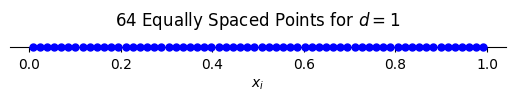

In [ ]:
n = 64
xpts = np.linspace(1/(2*n), 1-1/(2*n), n) #equally spaced points between 0 and 1
fig, ax = plt.subplots()
ax.plot(xpts, np.zeros_like(xpts), 'b.', markersize = 10, zorder=10, clip_on=False)
ax.set_ylim([0, 3e-2])
ax.set_title(f"{n:.0f} Equally Spaced Points for $d=1$")
ax.set_xlabel("$x_i$")
ax.set_aspect(1)
ax.axes.get_yaxis().set_visible(False)  #turn off the tics on the vertical axis
ax.spines[['top','right','left']].set_visible(False)  #turn off the bounding box on the top and sides
if savefigs:
    fig.savefig(figpath+f"{n:.0f}equallyspacedpts."+imgfrmt,format=imgfrmt)

### Grids in dimension $d$
Our natural thought for higher dimensions is to use rectangular grids, but as the dimension, $d$, increases, the number of different values per coordinate decreases drastically.

In [ ]:
def make_grid(d=3,nper=2):  #this function creates a nper^d x d matrix of grid points
    xpts = np.linspace(1/(2*nper), 1.0-1/(2*nper), nper)  #array of coordinate values
    xgrid = xpts  #initial grid
    n = nper  #initial length of grid
    for ii in range(1,d):
        xgrid0 = xgrid  #store the old grid
        xgrid = np.vstack((xgrid0,xpts[0]*np.ones((1,n))))  #stack the next coordinate
        for jj in range(1,nper):
            xgrid = np.hstack((xgrid,np.vstack((xgrid0,xpts[jj]*np.ones((1,n))))))
        n = n*nper  #update the length of the grid
    return xgrid.T  #take the transpose to that coordinates are columns

def plot_grid(xgrid, coord_to_plot = [0, 1], savefig = True, figpath = ''):
    n = xgrid.shape[0]
    d = xgrid.shape[1]
    coord_to_plot = np.minimum(coord_to_plot,[d,d]), #ensure that they are no more than d
    coord_to_plot = coord_to_plot[0]
    coord_to_plot = np.maximum(coord_to_plot,[1,1]), #ensure that they are no less than 1
    coord_to_plot = coord_to_plot[0]
    fig, ax = plt.subplots()
    ax.plot(xgrid[:,coord_to_plot[0]-1], xgrid[:,coord_to_plot[1]-1], 'b.', markersize = 10, zorder=10, clip_on=False)
    ax.set_title(f"{n:.0f} Grid Points for $d = ${d:.0f}")
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel(r'$x_{i%d}$'%(coord_to_plot[0]),fontsize=14)
    ax.set_ylabel(r'$x_{i%d}$'%(coord_to_plot[1]),fontsize=14)
    ax.set_aspect(1)
    if savefigs:
        fig.savefig(figpath+f"{n:.0f}gridpts_d{d:.0f}."+imgfrmt,format=imgfrmt)


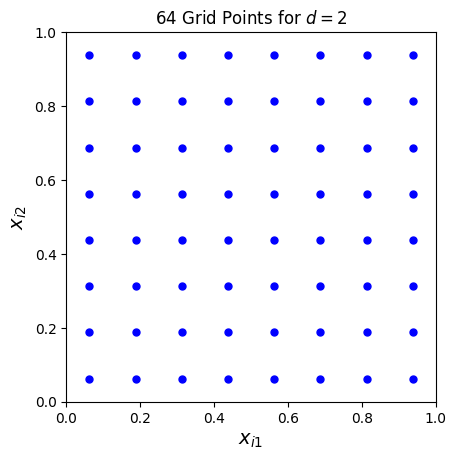

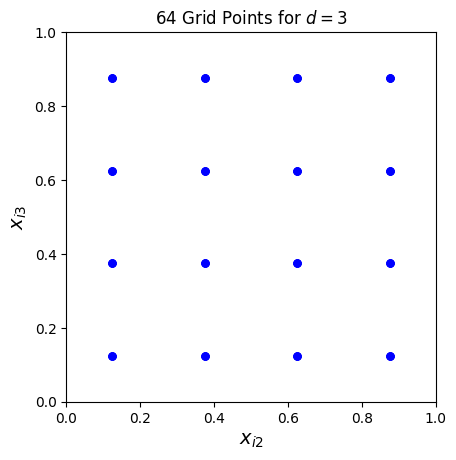

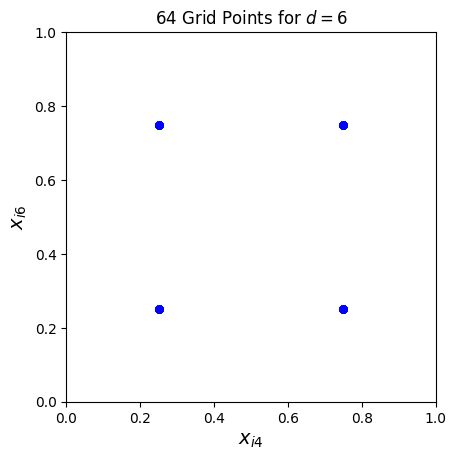

In [ ]:
plot_grid(make_grid(2,8), [1,2], savefigs, figpath)
plot_grid(make_grid(3,4), [2,3], savefigs, figpath)
plot_grid(make_grid(6,2), [4,6], savefigs, figpath)

### Independent and identically distributed (IID) points
Since grids are bad, we can use IID points instead.  Note how they fill space better.

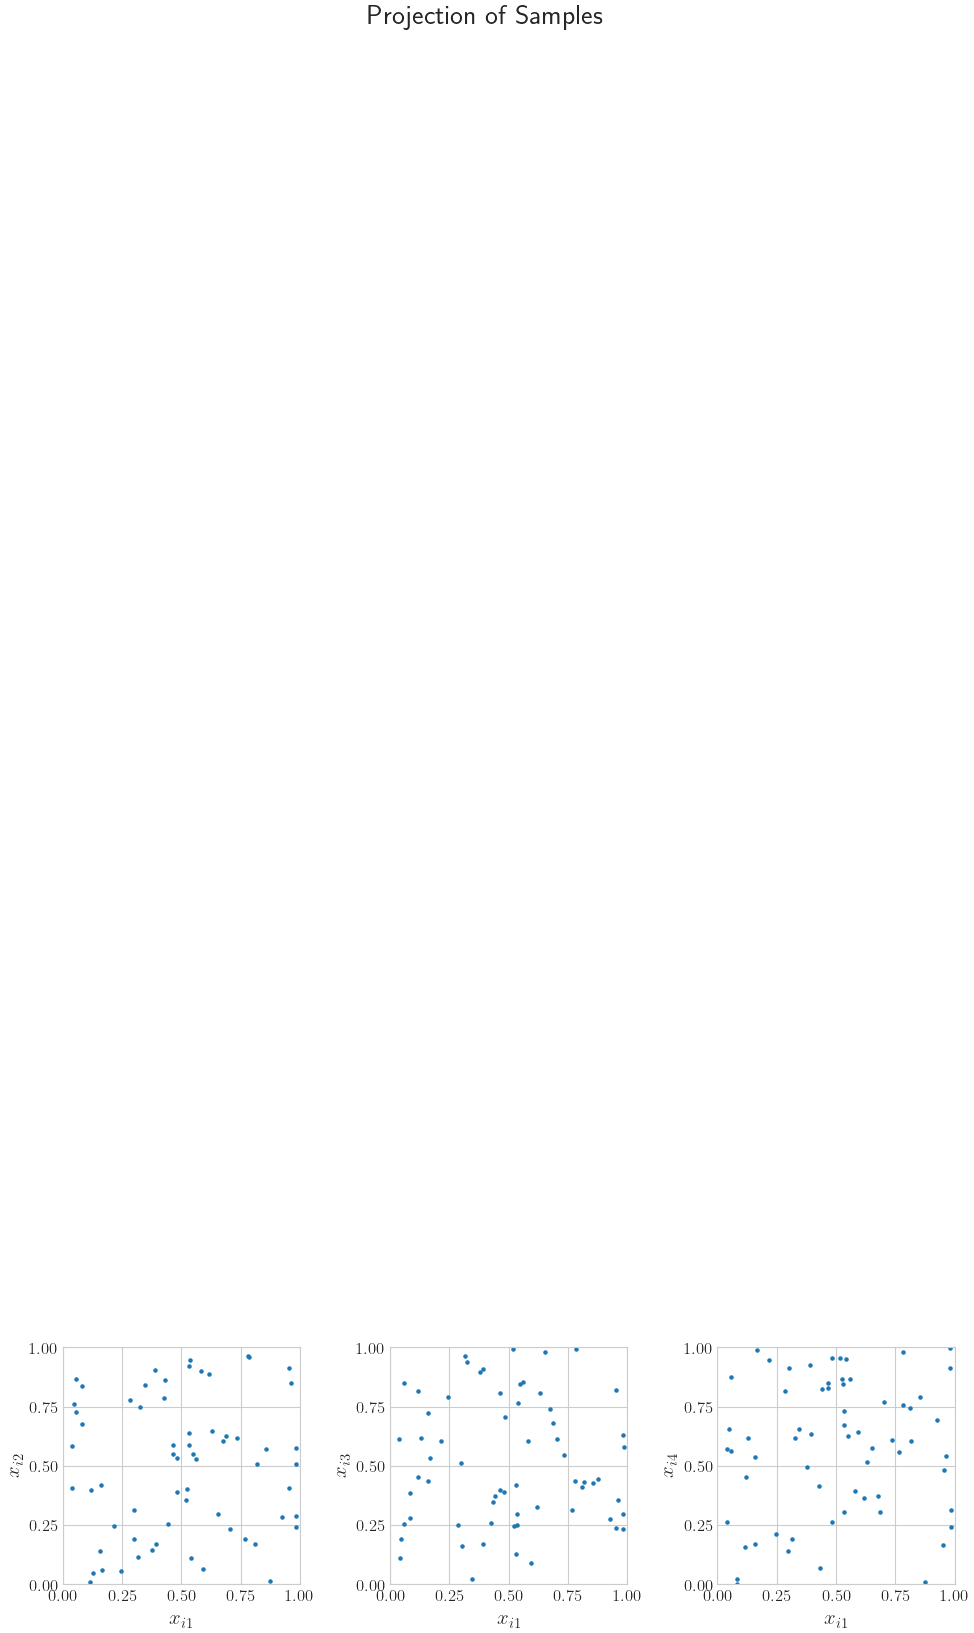

In [ ]:
d = 6  #the dimension used for these examples
n = 64  #the sample size used for these examples
fig,ax = qp.plot_proj(qp.IIDStdUniform(d), n, d_horizontal = 1, d_vertical = np.arange(2,5), figfac = 10)
# fig,ax = qp.plot_proj(qp.IIDStdUniform(d), n, d_horizontal = 1, d_vertical = np.arange(2,5), figfac = 10)
fig.suptitle('Projection of Samples',fontsize = 20)
if savefigs:
        fig.savefig(figpath+f"{n:.0f}iidpts_d{d:.0f}."+imgfrmt,format=imgfrmt)

### Low disrepancy points
There are several kinds of low discrepancy points, includng Sobol', lattice, and Halton.  Below we display one kind.

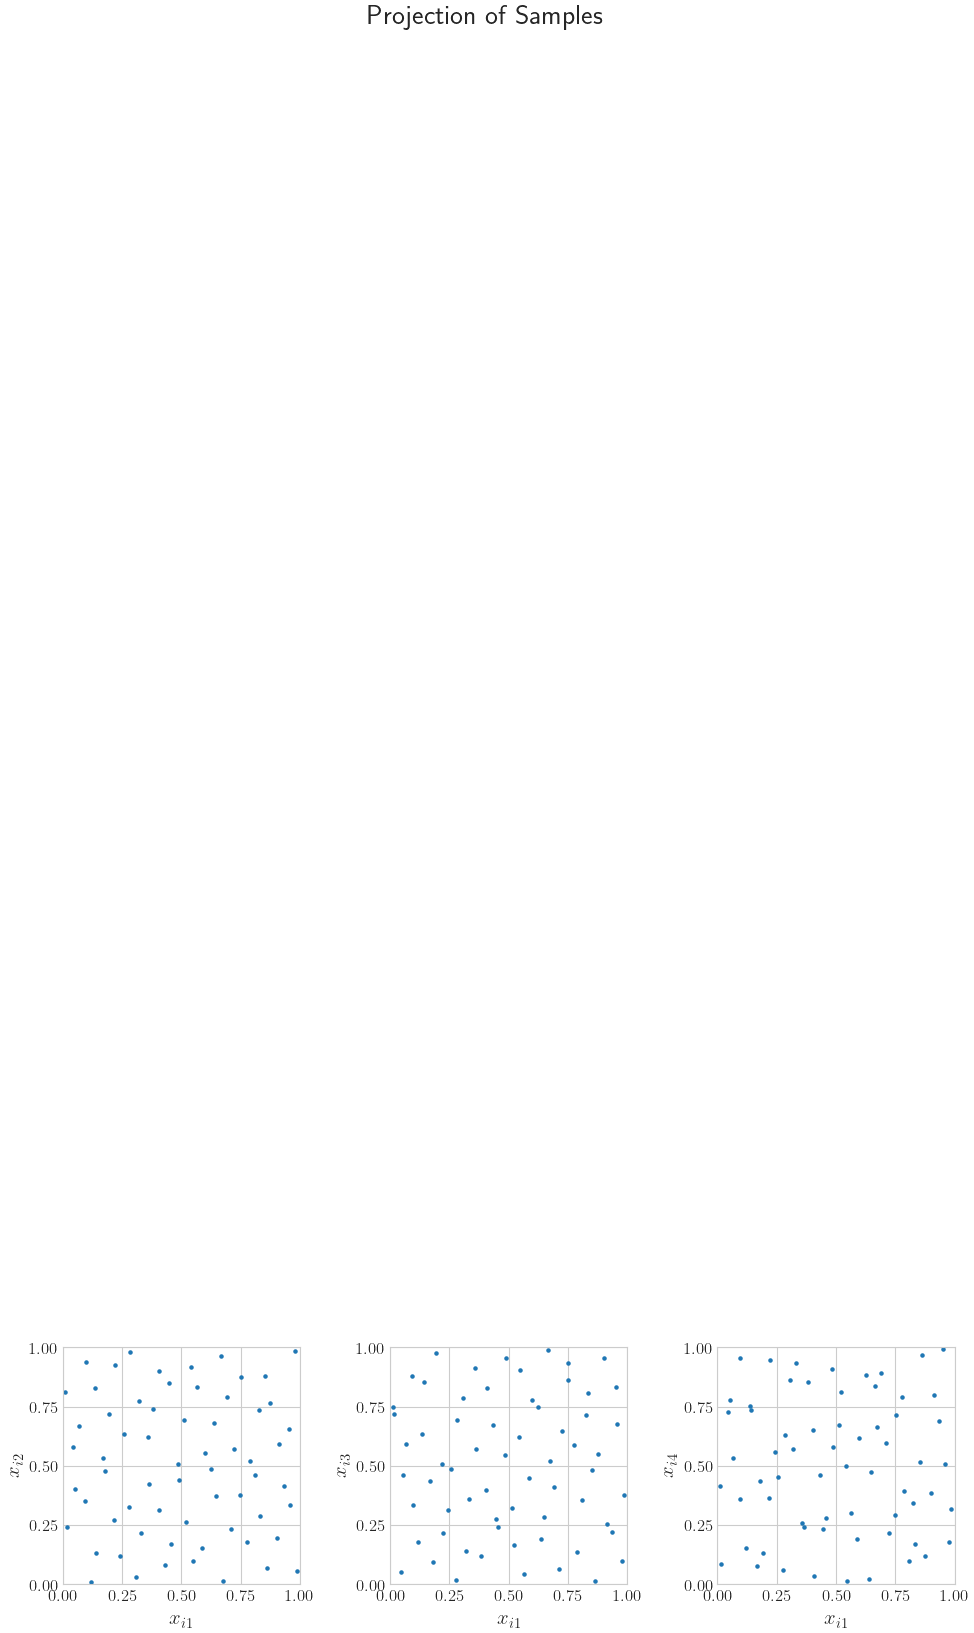

In [ ]:
fig,ax = qp.plot_proj(qp.Sobol(d), n, d_horizontal = 1, d_vertical = np.arange(2,5), figfac = 10)
# fig,ax = qp.plot_proj(qp.Sobol(d), n, d_horizontal = 1, d_vertical = np.arange(2,5), figfac = 10)
    #d_horizontal and d_vertical are the tuples of coordinates to plot
if savefigs:
        fig.savefig(figpath+f"{n:.0f}sobolpts_d{d:.0f}."+imgfrmt,format=imgfrmt)

## Kernel Density Estimation

### Gaussian kernel

In [ ]:
def kernel(y):
    return np.exp(-y*y)/np.sqrt(np.pi)

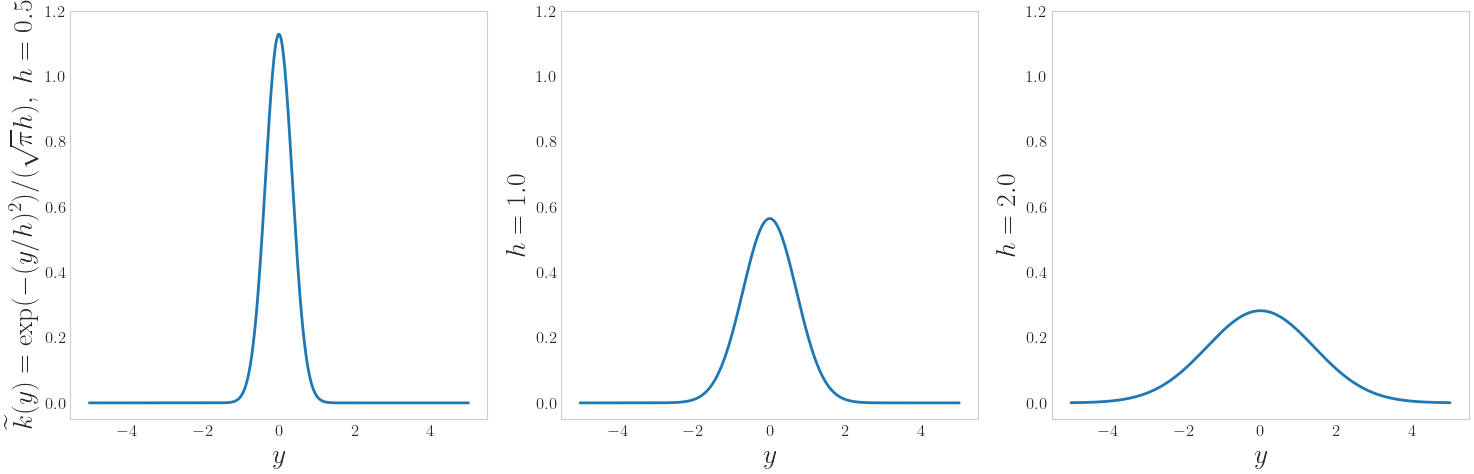

In [ ]:
# connection to dirac function? value is zero everywhere except at zero, and integral over the entire real line is equal to one
# low bandwidth (like 0.5) = taller peak, lighter tails. high bandwidth (like 2) = shorter peak, fatter tails

ypts = np.linspace(-5,5,500)
bandwidth = [0.5, 1, 2]
nband = len(bandwidth)
fig,ax = plt.subplots(1,3,figsize=(5*nband,5))
for ii in range(nband):
    ax[ii].plot(ypts,kernel(ypts/bandwidth[ii])/bandwidth[ii])
    ax[ii].grid(False)
    ax[ii].set_ylim([-0.05, 1.2])
    ax[ii].set_xlabel(r'$y$',fontsize=20)
    if (ii == 0):
        ax[ii].set_ylabel(r'$\widetilde{k}(y) = \exp(-(y/h)^2)/(\sqrt{\pi}h), \ h = {%0.1f}$'%bandwidth[ii],fontsize=20)
    else:
        ax[ii].set_ylabel(r'$h = {%0.1f}$'%bandwidth[ii],fontsize=20)
if savefigs:
        fig.savefig(figpath+"kernel."+imgfrmt,format=imgfrmt)

### Numerical experiment

#### Generate some $\vx_i$

In [ ]:
d = 3
coord_wts = 2.**(-np.array(range(0,d)))
n = 2**12
iidpts = qp.IIDStdUniform(d).gen_samples(n)
print("iid pts",iidpts)
wtiidpts = np.multiply(iidpts,coord_wts)
print(wtiidpts)
sobpts = qp.Sobol(d).gen_samples(n)
print("sobol pts",sobpts)

iid pts [[0.62231032 0.5032297  0.67533937]
 [0.07725515 0.71555867 0.98530282]
 [0.29725938 0.33694145 0.51777249]
 ...
 [0.83973993 0.86637628 0.41072519]
 [0.99783788 0.0561326  0.3087986 ]
 [0.164016   0.34047013 0.5058576 ]]
[[0.62231032 0.25161485 0.16883484]
 [0.07725515 0.35777933 0.24632571]
 [0.29725938 0.16847073 0.12944312]
 ...
 [0.83973993 0.43318814 0.1026813 ]
 [0.99783788 0.0280663  0.07719965]
 [0.164016   0.17023506 0.1264644 ]]
sobol pts [[0.85304095 0.23037848 0.96293335]
 [0.30599455 0.93561539 0.44275133]
 [0.70745899 0.68620354 0.00335243]
 ...
 [0.44863999 0.71851687 0.00150889]
 [0.53740996 0.96825867 0.44484625]
 [0.11582935 0.13527899 0.96184704]]


#### Generate some $y_i=f(x_i)$ points
$
f(\vx) = 10 \exp(- w_1x_1 - \cdots - w_d x_d) \sin(w_1x_1 + \cdots +w_d x_d)
$

In [ ]:
# function (f(x)) of random variable can change

def testfun(x,coord_wts = 1):
    wtx = np.multiply(x,coord_wts)
    y = 10*np.exp(-wtx.sum(1))*np.sin(np.pi*wtx.sum(1))
    #y = x[:,0]--if x is uniform, then y is uniform
    return y

In [ ]:
yiid = testfun(iidpts)
ysob = testfun(sobpts)

#### Construct a kernel density estimator

In [ ]:
def kde(kernel,ypts,bandwidth,yeval):
    neval = len(yeval)
    rhoval = np.zeros_like(yeval)
    for ii in range(len(yeval)):
        rhoval[ii] = np.mean(kernel((yeval[ii]-ypts)/bandwidth))/bandwidth
    return rhoval

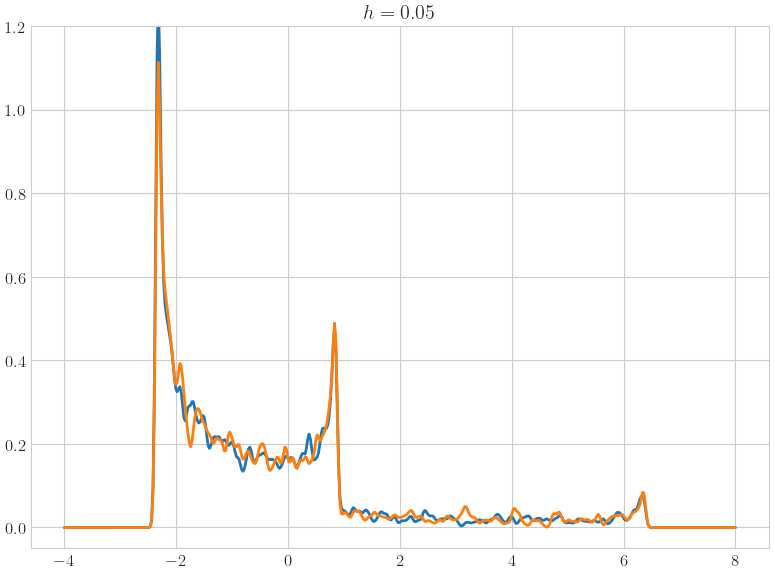

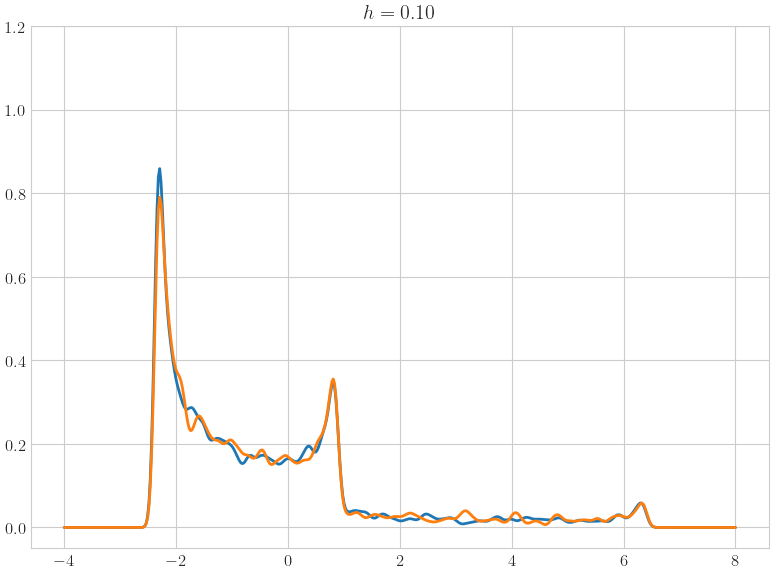

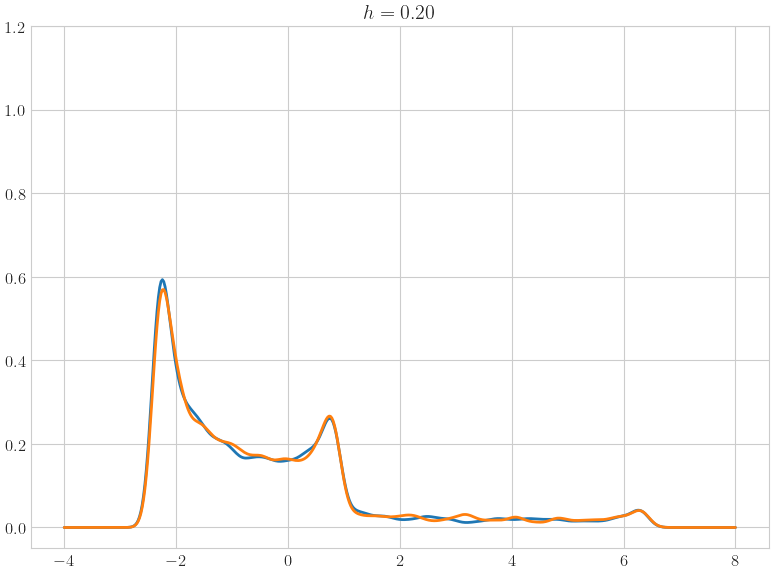

In [ ]:
bandwidth = [0.05, 0.1, 0.2]
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel,yiid,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,ysob,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid)
    ax.plot(yeval,rhovalsob)
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    if savefigs:
        fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

### Testing Different Bandwidths

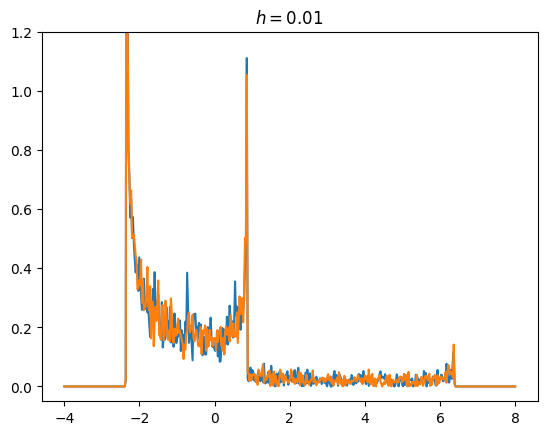

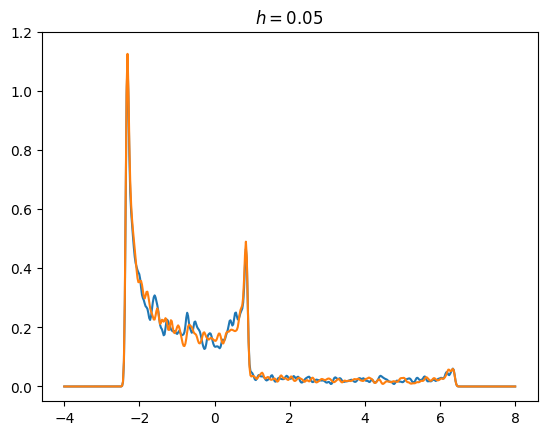

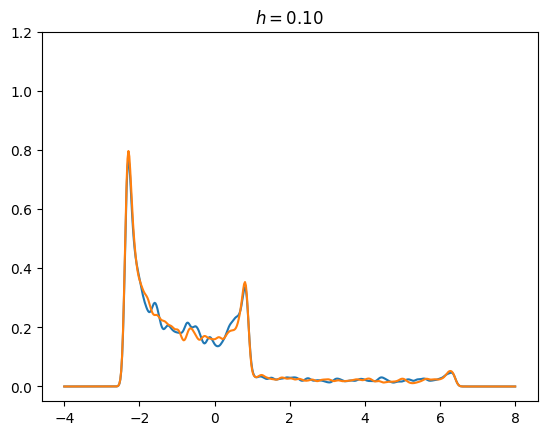

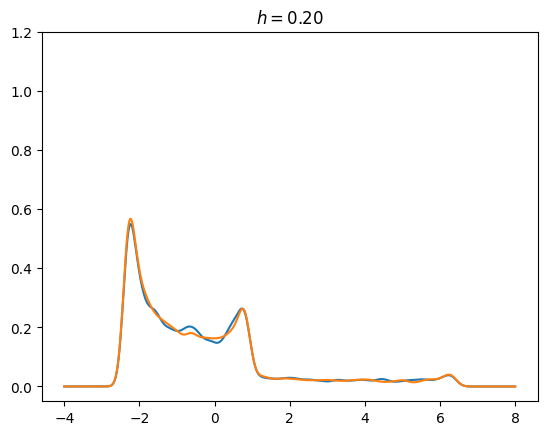

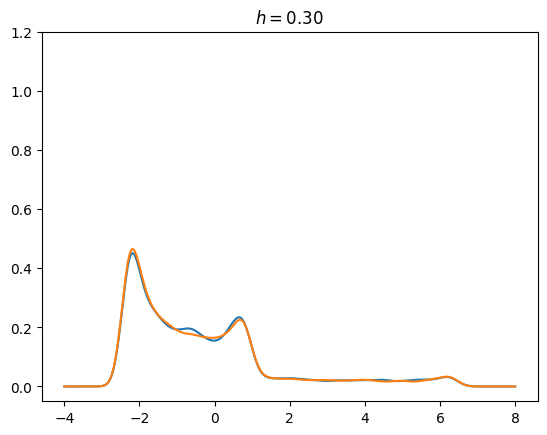

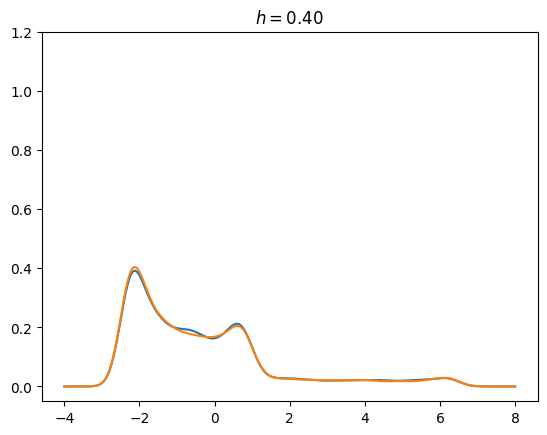

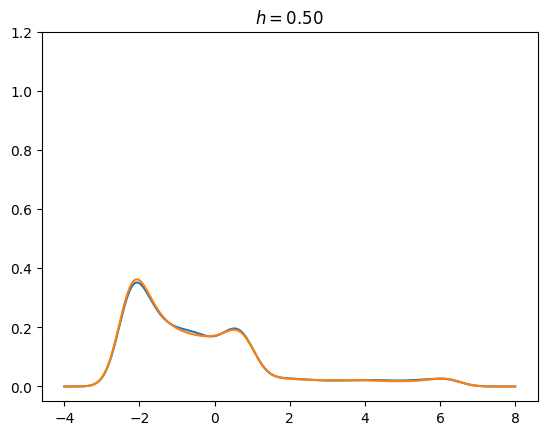

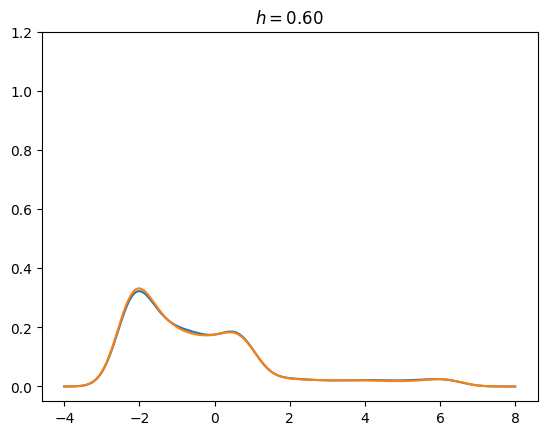

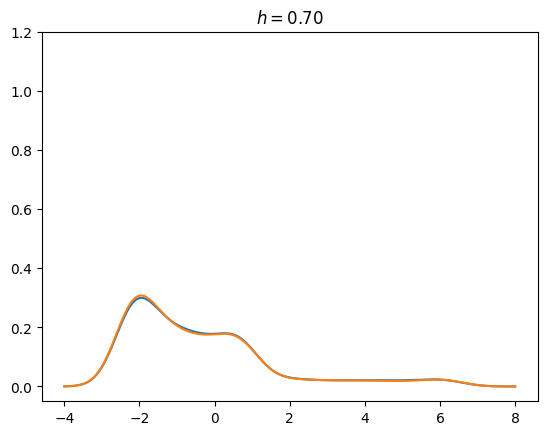

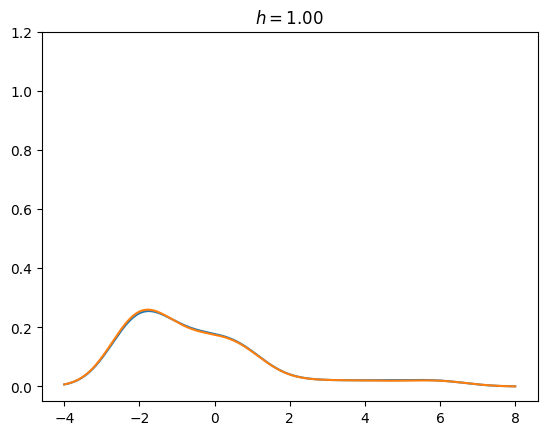

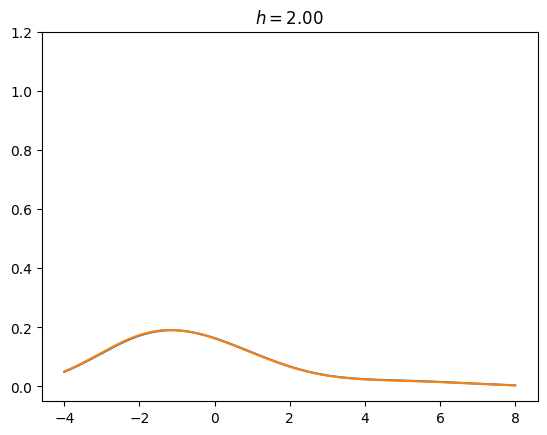

In [ ]:
## testing diff. bandwidths

bandwidth = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1, 2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel,yiid,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,ysob,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid)
    ax.plot(yeval,rhovalsob)
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    if savefigs:
        fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

In [ ]:
d = 3
coord_wts = 2.**(-np.array(range(0,d)))
n = 2**12
iidpts = qp.IIDStdUniform(d).gen_samples(n)
print("iid pts",iidpts)
wtiidpts = np.multiply(iidpts,coord_wts)
print(wtiidpts)
sobpts = qp.Sobol(d).gen_samples(n)
print("sobol pts",sobpts)

iid pts [[0.2823804  0.48447785 0.10669723]
 [0.87314115 0.85405605 0.93196845]
 [0.03701591 0.98337732 0.66069473]
 ...
 [0.76999379 0.09665362 0.18561198]
 [0.41167267 0.63487598 0.82962167]
 [0.68425286 0.32087918 0.90600864]]
[[0.2823804  0.24223892 0.02667431]
 [0.87314115 0.42702802 0.23299211]
 [0.03701591 0.49168866 0.16517368]
 ...
 [0.76999379 0.04832681 0.04640299]
 [0.41167267 0.31743799 0.20740542]
 [0.68425286 0.16043959 0.22650216]]
sobol pts [[0.21524081 0.08285944 0.71204584]
 [0.86561784 0.72155882 0.43065108]
 [0.47045966 0.79615247 0.22134044]
 ...
 [0.8857397  0.86386992 0.21945683]
 [0.27867105 0.68087992 0.43250566]
 [0.67904428 0.01465553 0.71409917]]


In [ ]:
def kde(kernel,ypts,bandwidth,yeval):
    neval = len(yeval)
    rhoval = np.zeros_like(yeval)
    for ii in range(len(yeval)):
        rhoval[ii] = np.mean(kernel((yeval[ii]-ypts)/bandwidth))/bandwidth
    return rhoval

In [ ]:
def testfun(x,coord_wts = 1):
    wtx = np.multiply(x,coord_wts)
    y = 10*np.exp(-wtx.sum(1))*np.sin(np.pi*wtx.sum(1))
    #y = x[:,0]
    return y

In [ ]:
yiid = testfun(iidpts)
ysob = testfun(sobpts)

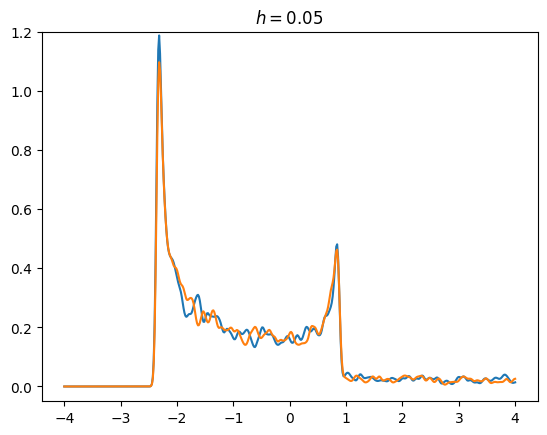

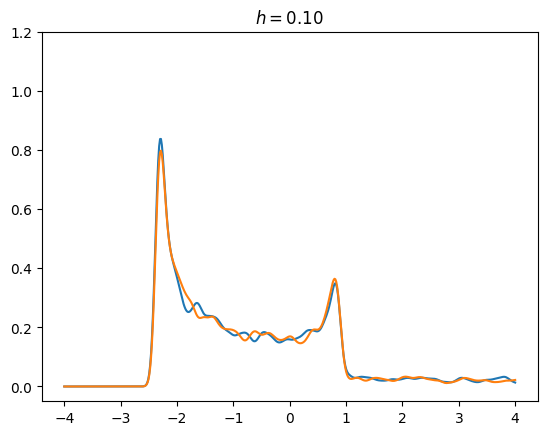

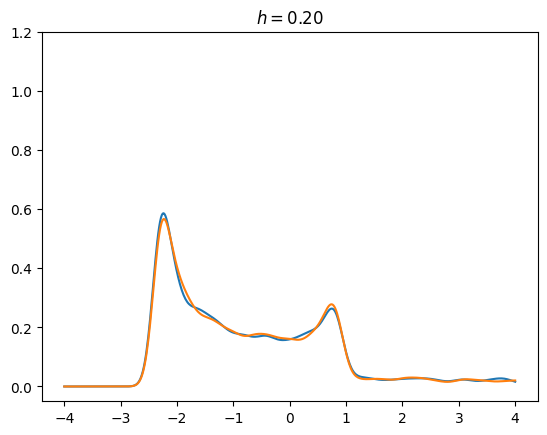

In [ ]:
## testing different x-axis ranges (changing linspace)--why is the mean not 0?

bandwidth = [0.05, 0.1, 0.2]
yeval = np.linspace(-4, 4,500)
nband = len(bandwidth)
for ii in range(nband):
    rhovaliid = kde(kernel,yiid,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,ysob,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid)
    ax.plot(yeval,rhovalsob)
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    if savefigs:
        fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

### Testing different LD sequences

In [ ]:
## testing different LD generators
## different distributions--only certain ones work with certain functions though
# discrete_distribs = {
#     'IID': qp.IIDStdUniform(2),
#     'LD Lattice': qp.Lattice(2),
#     'LD Digital Net': qp.DigitalNetB2(2),
#     'LD Halton': qp.Halton(2)}

d = 3
coord_wts = 2.**(-np.array(range(0,d)))
n = 2**12
iidpts = qp.IIDStdUniform(d).gen_samples(n)
print("iid pts",iidpts)
wtiidpts = np.multiply(iidpts,coord_wts)
print(wtiidpts)
latticepts = qp.Lattice(d).gen_samples(n)
print("lattice pts",latticepts)
dnetb2pts = qp.DigitalNetB2(d).gen_samples(n)
print("Digital Net B2 pts",dnetb2pts)
haltonpts = qp.Halton(d).gen_samples(n)
print("halton pts",haltonpts)

iid pts [[0.79912742 0.59394921 0.41386288]
 [0.65329936 0.26842137 0.70645785]
 [0.99632937 0.10470406 0.42399504]
 ...
 [0.46512623 0.77412787 0.66585711]
 [0.83600426 0.28375153 0.73853016]
 [0.35213495 0.35681124 0.1908989 ]]
[[0.79912742 0.29697461 0.10346572]
 [0.65329936 0.13421068 0.17661446]
 [0.99632937 0.05235203 0.10599876]
 ...
 [0.46512623 0.38706393 0.16646428]
 [0.83600426 0.14187576 0.18463254]
 [0.35213495 0.17840562 0.04772473]]
lattice pts [[0.8425094  0.82317243 0.73574425]
 [0.3425094  0.32317243 0.23574425]
 [0.0925094  0.57317243 0.48574425]
 ...
 [0.59226526 0.47673688 0.26626183]
 [0.34226526 0.72673688 0.51626183]
 [0.84226526 0.22673688 0.01626183]]
Digital Net B2 pts [[0.26280409 0.91636502 0.78945163]
 [0.61338824 0.30689462 0.10542194]
 [0.03877854 0.228815   0.31890022]
 ...
 [0.74569088 0.17253535 0.31712837]
 [0.16430617 0.34436781 0.10328366]
 [0.95434344 0.98508058 0.79134573]]
halton pts [[0.37287062 0.14082121 0.13245192]
 [0.87287062 0.47415455 0.

In [ ]:
yiid = testfun(iidpts)
ylattice = testfun(latticepts)
ydnetb2 = testfun(dnetb2pts)
yhalton = testfun(haltonpts)

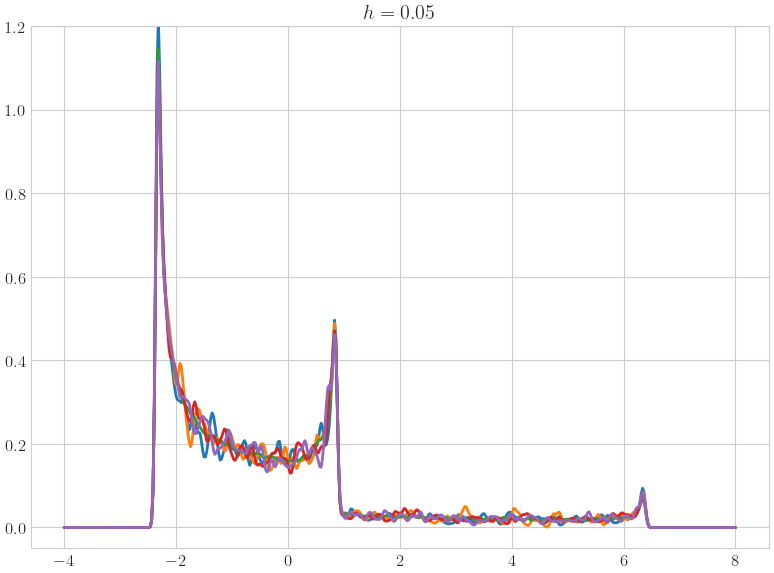

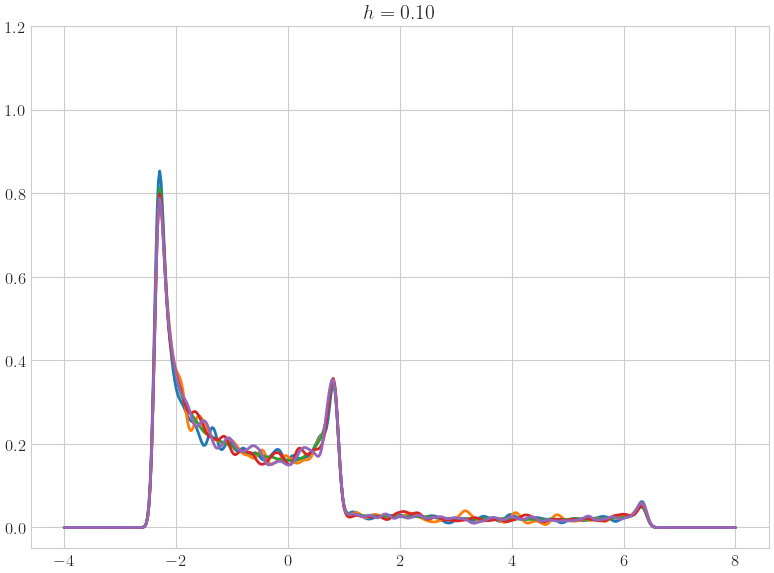

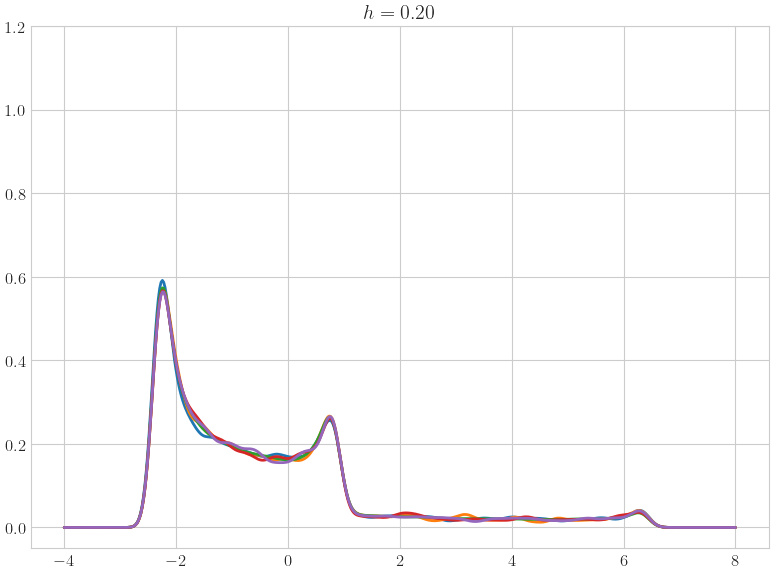

In [ ]:
bandwidth = [0.05, 0.1, 0.2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel,yiid,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,ysob,bandwidth[ii],yeval)
    rhovallattice = kde(kernel,ylattice,bandwidth[ii],yeval)
    rhovaldnetb2 = kde(kernel,ydnetb2,bandwidth[ii],yeval)
    rhovalhalton = kde(kernel,yhalton,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid)
    ax.plot(yeval,rhovalsob)
    ax.plot(yeval,rhovallattice)
    ax.plot(yeval,rhovaldnetb2)
    ax.plot(yeval,rhovalhalton)
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    if savefigs:
        fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

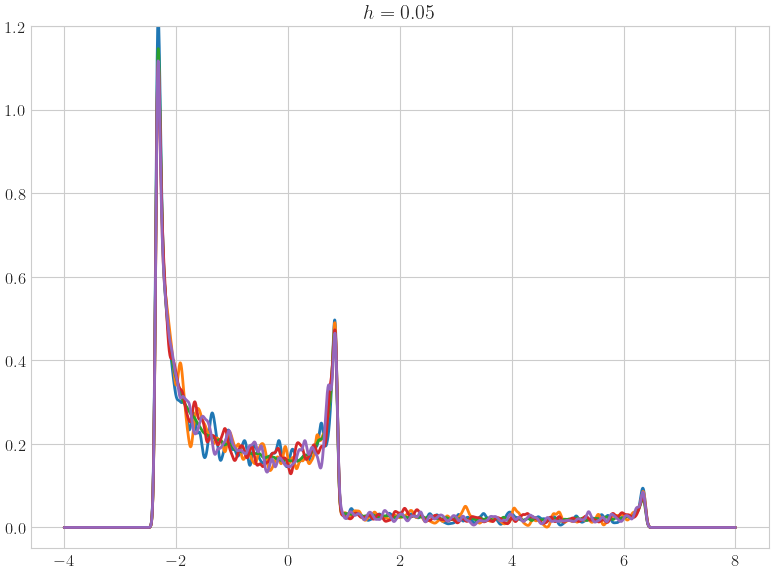

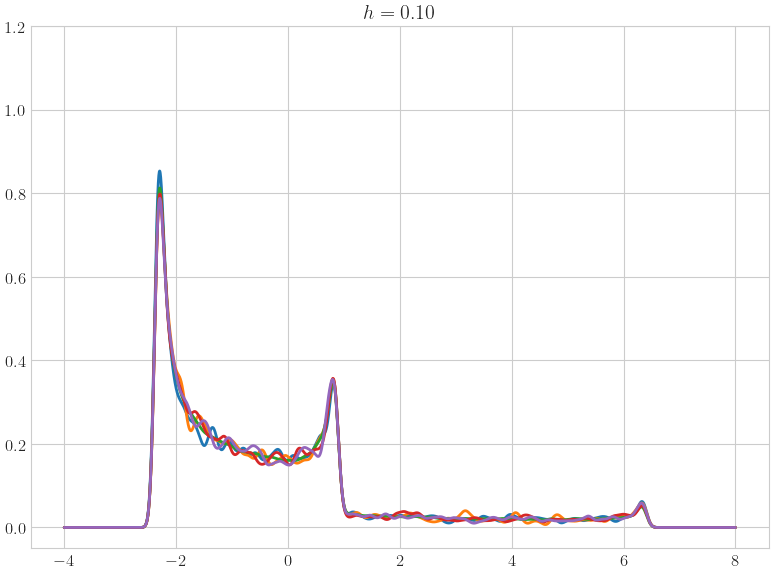

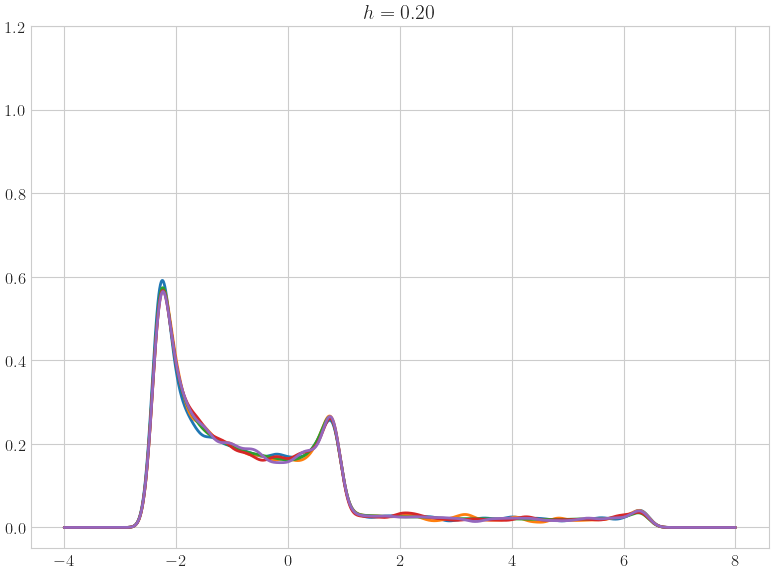

In [ ]:
## testing different sample size for yeval, not much difference

bandwidth = [0.05, 0.1, 0.2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,4096)
for ii in range(nband):
    rhovaliid = kde(kernel,yiid,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,ysob,bandwidth[ii],yeval)
    rhovallattice = kde(kernel,ylattice,bandwidth[ii],yeval)
    rhovaldnetb2 = kde(kernel,ydnetb2,bandwidth[ii],yeval)
    rhovalhalton = kde(kernel,yhalton,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid)
    ax.plot(yeval,rhovalsob)
    ax.plot(yeval,rhovallattice)
    ax.plot(yeval,rhovaldnetb2)
    ax.plot(yeval,rhovalhalton)
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    if savefigs:
        fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

## Visualizing LD sequences

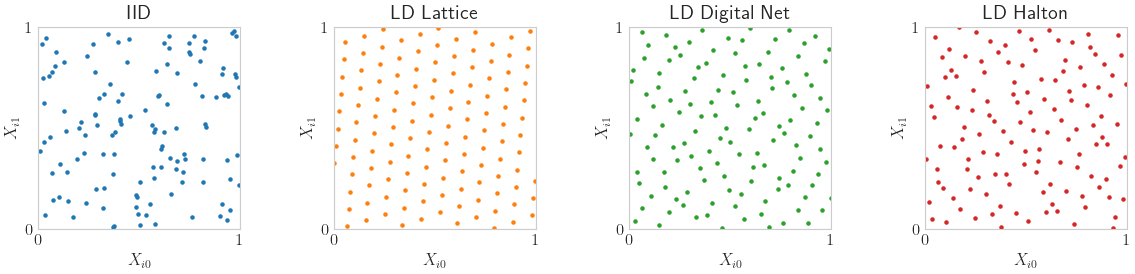

In [ ]:
# Aleksei's tutorial: visualizing sequences

from matplotlib import pyplot
colors = pyplot.rcParams['axes.prop_cycle'].by_key()['color']
n = 2**7 # Lattice and Digital Net prefer powers of 2 sample sizes--choose power of 2 b/c it fills the grid better
discrete_distribs = {
    'IID': qp.IIDStdUniform(2),
    'LD Lattice': qp.Lattice(2),
    'LD Digital Net': qp.DigitalNetB2(2),
    'LD Halton': qp.Halton(2)}
fig,ax = pyplot.subplots(nrows=1,ncols=len(discrete_distribs),figsize=(3*len(discrete_distribs),3))
ax = np.atleast_1d(ax)
for i,(name,discrete_distrib) in enumerate(discrete_distribs.items()):
    x = discrete_distrib.gen_samples(n)
    ax[i].scatter(x[:,0],x[:,1],s=5,color=colors[i])
    ax[i].set_title(name)
    ax[i].set_aspect(1)
    ax[i].set_xlabel(r'$X_{i0}$'); ax[i].set_ylabel(r'$X_{i1}$')
    ax[i].set_xlim([0,1]); ax[i].set_ylim([0,1])
    ax[i].set_xticks([0,1]); ax[i].set_yticks([0,1])

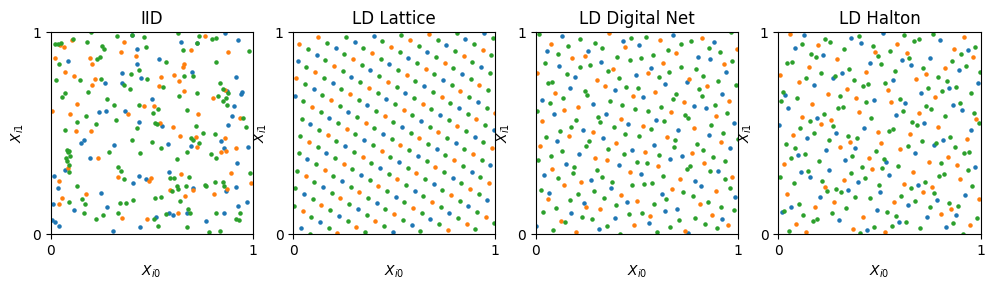

In [ ]:
# LD space filling extensibility: as you double sample size, you fill in the gaps left by earlier points in the sequence

m_min,m_max = 6,8 # stopping criterion will double sample size until criterion is met
# extensibility = as you double sample size, you fill in the gaps left by earlier points in the sequence
fig,ax = pyplot.subplots(nrows=1,ncols=len(discrete_distribs),figsize=(3*len(discrete_distribs),3))
ax = np.atleast_1d(ax)
for i,(name,discrete_distrib) in enumerate(discrete_distribs.items()):
    x = discrete_distrib.gen_samples(2**m_max)
    n_min = 0
    for m in range(m_min,m_max+1):
        n_max = 2**m
        ax[i].scatter(x[n_min:n_max,0],x[n_min:n_max,1],s=5,color=colors[m-m_min],label='n_min = %d, n_max = %d'%(n_min,n_max))
        n_min = 2**m
    ax[i].set_title(name)
    ax[i].set_aspect(1)
    ax[i].set_xlabel(r'$X_{i0}$'); ax[i].set_ylabel(r'$X_{i1}$')
    ax[i].set_xlim([0,1]); ax[i].set_ylim([0,1])
    ax[i].set_xticks([0,1]); ax[i].set_yticks([0,1])

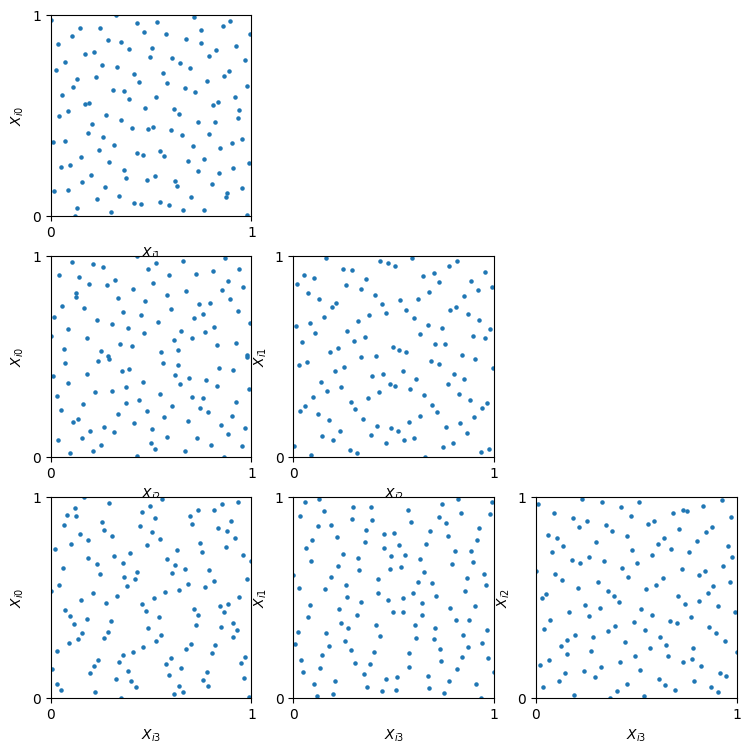

In [ ]:
# high dimensional pairs plotting

discrete_distrib = qp.DigitalNetB2(4)
x = discrete_distrib(2**7)
d = discrete_distrib.d
assert d>=2
fig,ax = pyplot.subplots(nrows=d,ncols=d,figsize=(3*d,3*d))
for i in range(d):
    fig.delaxes(ax[i,i])
    for j in range(i):
        ax[i,j].scatter(x[:,i],x[:,j],s=5)
        fig.delaxes(ax[j,i])
        ax[i,j].set_aspect(1)
        ax[i,j].set_xlabel(r'$X_{i%d}$'%i); ax[i,j].set_ylabel(r'$X_{i%d}$'%j)
        ax[i,j].set_xlim([0,1]); ax[i,j].set_ylim([0,1])
        ax[i,j].set_xticks([0,1]); ax[i,j].set_yticks([0,1])

## Integration

Define original integrand $g$, store transformed integrand $f$

Our simple example
$$g(T) = T_0+T_1+\dots+T_{d-1}, \qquad T \sim N(0,I_d)$$
$$f(X) = g(\Phi^{-1}(X)), \qquad \Phi \text{ standard normal CDF}$$
$$\mathbb{E}[f(X)] = \mathbb{E}[g(T)] = 0$$

In [ ]:
## integration (using standard gaussian):

def myfun(t): # define g, the ORIGINAL integrand
    # t an (n,d) shaped np.ndarray of sample from the ORIGINAL (true) measure
    y = t.sum(1)
    return y # an (n,) shaped np.ndarray
true_measure = qp.Gaussian(qp.Halton(5)) # LD Halton discrete distrib for QMC problem
qp_myfun = qp.CustomFun(true_measure,myfun,parallel=False) # CustumFun = Integrand wrapper for a user’s function, TrueMeasure = an abstract class

In [ ]:
x = qp_myfun.discrete_distrib.gen_samples(4) # samples from the TRANSFORMED measure (transformation done behind the scenes--only need to specify true measure, and will trasnform for you)
y = qp_myfun.f(x) # evaluate the TRANSFORMED integrand at the TRANSFORMED samples
y

array([[-0.43454624],
       [-2.13188064],
       [ 0.75801743],
       [-1.71639429]])

In [ ]:
x = qp_myfun.discrete_distrib.gen_samples(2**16) # samples from the TRANSFORMED measure
y = qp_myfun.f(x) # evaluate the TRANSFORMED integrand at the TRANSFORMED samples
mu_hat = y.mean()
mu_hat # true mean is 0 (std normal), mu_hat is approximated mean

0.0001037427577546844

### Pre-defined integrands

In [ ]:
asian_option = qp.AsianOption( # application in quantitative finance
    sampler = qp.DigitalNetB2(52),
    volatility = 1/2,
    start_price = 30,
    strike_price = 35,
    interest_rate = 0.001,
    t_final = 1,
    call_put = 'call',
    mean_type = 'arithmetic')
asian_option

AsianOption (Integrand Object)
    volatility      2^(-1)
    call_put        call
    start_price     30
    strike_price    35
    interest_rate   0.001
    mean_type       arithmetic
    dim_frac        0

In [ ]:
x = asian_option.discrete_distrib.gen_samples(2**16)
y = asian_option.f(x)
mu_hat = y.mean()
mu_hat

1.7888629602749961

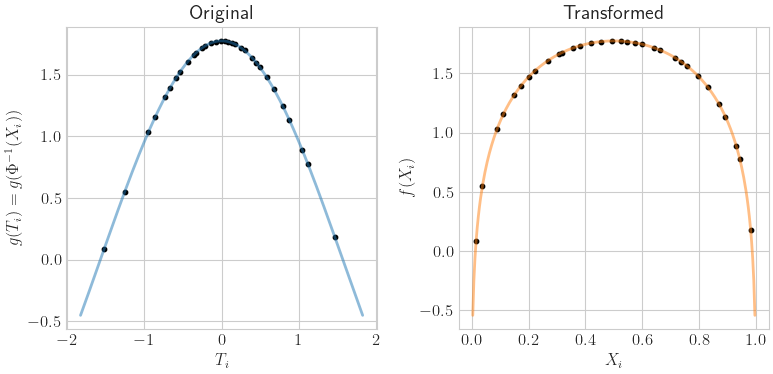

In [ ]:
n = 32
keister = qp.Keister(qp.DigitalNetB2(1))
fig,ax = pyplot.subplots(nrows=1,ncols=2,figsize=(8,4))
x = keister.discrete_distrib.gen_samples(n)
t = keister.true_measure.gen_samples(n)
f_of_x = keister.f(x).squeeze()
g_of_t = keister.g(t).squeeze()
assert (f_of_x==g_of_t).all()
x_fine = np.linspace(0,1,257)[1:-1,None]
f_of_xfine = keister.f(x_fine).squeeze()
lb = 1.2*max(abs(t.min()),abs(t.max()))
t_fine = np.linspace(-lb,lb,257)[:,None]
g_of_tfine = keister.g(t_fine).squeeze()
ax[0].set_title(r'Original')
ax[0].set_xlabel(r'$T_i$'); ax[0].set_ylabel(r'$g(T_i) = g(\Phi^{-1}(X_i))$')
ax[0].plot(t_fine.squeeze(),g_of_tfine,color=colors[0],alpha=.5)
ax[0].scatter(t.squeeze(),f_of_x,s=10,color='k')
ax[1].set_title(r'Transformed')
ax[1].set_xlabel(r'$X_i$'); ax[1].set_ylabel(r'$f(X_i)$')
ax[1].scatter(x.squeeze(),f_of_x,s=10,color='k')
ax[1].plot(x_fine.squeeze(),f_of_xfine,color=colors[1],alpha=.5);

### Stopping Criterion

Adaptively increase $n$ until $\lvert \mu - \widehat{\mu} \rvert < \varepsilon$ where $\varepsilon$ is a user defined tolerance.

The stopping criterion should match the discrete distribution e.g. IID CMC stopping criterion for IID points, QMC Lattice stopping criterion for LD Lattice points, QMC digital net stopping criterion for LD digital net points, etc.

In [ ]:
problem_cmc = qp.AsianOption(qp.IIDStdUniform(52)) # start with IID points in 52 dimensions (i.e., one for each week of the year)
cmc_stop_crit = qp.CubMCG(problem_cmc,abs_tol=0.025) # cubature algorithm, set tolerance to 0.025
approx_cmc,data_cmc = cmc_stop_crit.integrate() # cmc = crude monte carlo b/c we're using IID points
data_cmc # data object

MeanVarData (AccumulateData Object)
    solution        1.779
    error_bound     0.025
    n_total         539067
    n               538043
    levels          1
    time_integrate  4.204
CubMCG (StoppingCriterion Object)
    abs_tol         0.025
    rel_tol         0
    n_init          2^(10)
    n_max           10000000000
    inflate         1.200
    alpha           0.010
AsianOption (Integrand Object)
    volatility      2^(-1)
    call_put        call
    start_price     30
    strike_price    35
    interest_rate   0
    mean_type       arithmetic
    dim_frac        0
BrownianMotion (TrueMeasure Object)
    time_vec        [0.019 0.038 0.058 ... 0.962 0.981 1.   ]
    drift           0
    mean            [0. 0. 0. ... 0. 0. 0.]
    covariance      [[0.019 0.019 0.019 ... 0.019 0.019 0.019]
                    [0.019 0.038 0.038 ... 0.038 0.038 0.038]
                    [0.019 0.038 0.058 ... 0.058 0.058 0.058]
                    ...
                    [0.019 0.038 0.058

In [ ]:
problem_qmc = qp.AsianOption(qp.DigitalNetB2(52)) # swap in a low-discrepancy generator--digital net low discrepancy sequence
qmc_stop_crit = qp.CubQMCNetG(problem_qmc,abs_tol=0.025) # quasi monte carlo cubature algorithm
approx_qmc,data_qmc = qmc_stop_crit.integrate() # qmc = quasi monte carlo
data_qmc # takes less samples (n), time_integrate is faster

LDTransformData (AccumulateData Object)
    solution        1.785
    comb_bound_low  1.772
    comb_bound_high 1.798
    comb_flags      1
    n_total         2^(11)
    n               2^(11)
    time_integrate  0.031
CubQMCNetG (StoppingCriterion Object)
    abs_tol         0.025
    rel_tol         0
    n_init          2^(10)
    n_max           2^(35)
AsianOption (Integrand Object)
    volatility      2^(-1)
    call_put        call
    start_price     30
    strike_price    35
    interest_rate   0
    mean_type       arithmetic
    dim_frac        0
BrownianMotion (TrueMeasure Object)
    time_vec        [0.019 0.038 0.058 ... 0.962 0.981 1.   ]
    drift           0
    mean            [0. 0. 0. ... 0. 0. 0.]
    covariance      [[0.019 0.019 0.019 ... 0.019 0.019 0.019]
                    [0.019 0.038 0.038 ... 0.038 0.038 0.038]
                    [0.019 0.038 0.058 ... 0.058 0.058 0.058]
                    ...
                    [0.019 0.038 0.058 ... 0.962 0.962 0.962]

In [ ]:
print('QMC took %.2f%% the time and %.2f%% the samples compared to CMC'%(
      100*data_qmc.time_integrate/data_cmc.time_integrate,100*data_qmc.n_total/data_cmc.n_total))

QMC took 0.75% the time and 0.38% the samples compared to CMC


#### Visual CMC vs. LD

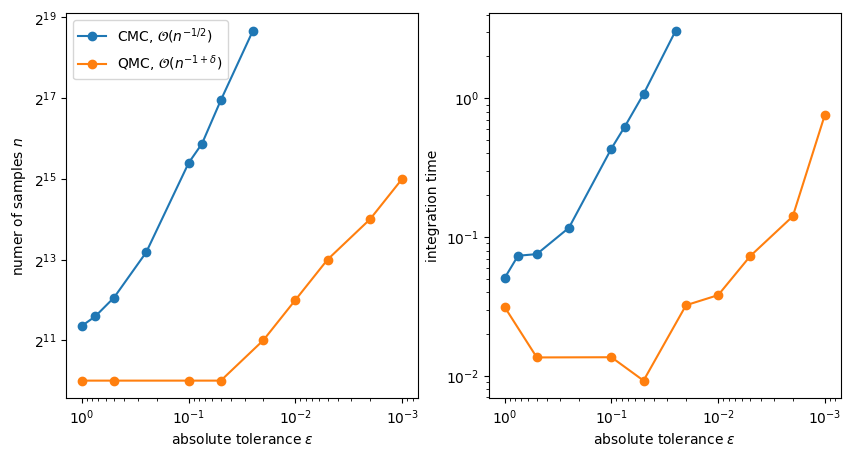

In [ ]:
cmc_tols = [1,.75,.5,.25,.1,.075,.05,.025]
qmc_tols = [1,.5,.1,.05,.02,.01,.005,.002,.001]

# x axis: tolerance decreasing. y-axis: number of samples & integration time. for QMC, takes less time & less samples as CMC (better approximation for same amt of time & same # samples)

fig,ax = pyplot.subplots(nrows=1,ncols=2,figsize=(10,5))
n_cmc,time_cmc = np.zeros_like(cmc_tols),np.zeros_like(cmc_tols)
for i,cmc_tol in enumerate(cmc_tols):
    cmc_stop_crit = qp.CubMCG( qp.AsianOption(qp.IIDStdUniform(52)),abs_tol=cmc_tol)
    approx_cmc,data_cmc = cmc_stop_crit.integrate()
    n_cmc[i],time_cmc[i] = data_cmc.n_total,data_cmc.time_integrate
ax[0].plot(cmc_tols,n_cmc,'-o',color=colors[0],label=r'CMC, $\mathcal{O}(n^{-1/2})$')
ax[1].plot(cmc_tols,time_cmc,'-o',color=colors[0])
n_qmc,time_qmc = np.zeros_like(qmc_tols),np.zeros_like(qmc_tols)
for i,qmc_tol in enumerate(qmc_tols):
    qmc_stop_crit = qp.CubQMCNetG(qp.AsianOption(qp.DigitalNetB2(52)),abs_tol=qmc_tol)
    approx_qmc,data_qmc = qmc_stop_crit.integrate()
    n_qmc[i],time_qmc[i] = data_qmc.n_total,data_qmc.time_integrate
ax[0].plot(qmc_tols,n_qmc,'-o',color=colors[1],label=r'QMC, $\mathcal{O}(n^{-1+\delta})$')
ax[1].plot(qmc_tols,time_qmc,'-o',color=colors[1])
ax[0].set_xscale('log',base=10); ax[0].set_yscale('log',base=2)
ax[1].set_xscale('log',base=10); ax[1].set_yscale('log',base=10)
ax[0].invert_xaxis(); ax[1].invert_xaxis()
ax[0].set_xlabel(r'absolute tolerance $\varepsilon$'); ax[1].set_xlabel(r'absolute tolerance $\varepsilon$')
ax[0].set_ylabel(r'numer of samples $n$'); ax[1].set_ylabel('integration time')
ax[0].legend(loc='upper left');

#### Vectorized Stopping Criterion

Many more examples available at https://github.com/QMCSoftware/QMCSoftware/blob/master/demos/vectorized_qmc.ipynb


As a simple example, lets compute $\mathbb{E}[\cos(T_0)\cdots\cos(T_{d-1})]$ and $\mathbb{E}[\sin(T_0)\cdots\sin(T_{d-1})]$ where $T \sim U[0,\pi]^d$

In [ ]:
# computing two expectations simultaneously--re-use low-discrepancy points, more efficient than using a for loop that regenerates points
# takes an n by d array of samples T, returns an n x 2 matrix with the expectations

qmc_stop_crit = qp.CubQMCCLT(
    integrand = qp.CustomFun(
        true_measure = qp.Uniform(sampler=qp.Halton(3),lower_bound=0,upper_bound=np.pi),
        g = lambda t,compute_flags: np.vstack([np.cos(t).prod(1),np.sin(t).prod(1)]).T, # compute_flags: if true, then continue computing solution; if not, then don't compute
        dimension_indv = 2),
    abs_tol=.0001) # low tolerance
approx,data = qmc_stop_crit.integrate()
data

MeanVarDataRep (AccumulateData Object)
    solution        [7.498e-06 2.580e-01]
    comb_bound_low  [-4.091e-05  2.579e-01]
    comb_bound_high [5.590e-05 2.581e-01]
    comb_flags      [ True  True]
    n_total         2^(18)
    n               [262144. 131072.]
    n_rep           [16384.  8192.]
    time_integrate  0.271
CubQMCCLT (StoppingCriterion Object)
    inflate         1.200
    alpha           0.010
    abs_tol         1.00e-04
    rel_tol         0
    n_init          2^(8)
    n_max           2^(30)
    replications    2^(4)
CustomFun (Integrand Object)
Uniform (TrueMeasure Object)
    lower_bound     0
    upper_bound     3.142
Halton (DiscreteDistribution Object)
    d               3
    dvec            [0 1 2]
    randomize       QRNG
    generalize      1
    entropy         295277168036485235195785978354659173369
    spawn_key       ()

### Guillem's density estimation

In [ ]:
from qmcpy import *
import numpy as np
from pandas import *
import scipy as sc
from sympy import *
import matplotlib.pyplot as plt
from scipy.special import erf
import math

In [ ]:
class RQMCEstimator:
    def __init__(self, n=1024, h=0.001,k=lambda x:1/np.sqrt(2*np.pi)*np.exp(-x**2/2),sequence='Sobol'):
        #self.g=lambda x:1/np.sqrt(2*np.pi)*np.exp(-x**2/2)
        self.n=n
        self.h=h
        self.k=k
        if sequence=='Sobol':
            self.sampler=Sobol(1).gen_samples(n)

        elif sequence=='Lattice':
            self.sampler=Lattice(1).gen_samples(n)

        else:
            raise ValueError("Invalid input. Must be Sobol or Lattice")

    def mise(self):
        est=np.squeeze(self.density_estimation())
        #real_distrib=self.gaussian(self.points,2, 1) we define a distribution to estimate
        integrand=((est-real_distrib)*np.random.normal(2,1,self.m))**2
        ex=np.trapz(integrand)
        return ex
        return mise



class OptionEstimator(RQMCEstimator):
    def __init__(self, n=1024, h=0.001,k=lambda x:1/np.sqrt(2*np.pi)*np.exp(-x**2/2),sequence='Sobol', K=30, S0=50, T=1,
                 option='EPO'):
        super().__init__(n, h,k,sequence)
        self.option=option
        if option=='ECO':
            self.T=T
            self.K=K
            r=0.1
            sigma=0.2
            self.S0=S0
        elif option=='EPO':
            self.T=T
            self.K=K
            r=0.1
            sigma=0.2
            self.S0=S0
        else:
            raise ValueError("Invalid input. Must be ECO or EPO")
        self.n=n
        self.h=h
        self.k=k
        self.s=lambda x:self.S0*np.exp((r-sigma**2/2)*self.T+sigma*np.sqrt(self.T)*sc.stats.norm.ppf(x))
    def density_estimation(self,x):
        if self.option=='ECO':
            f=zeros(len(x),1)
            g=np.maximum(self.s(self.sampler)-self.K,0)
            for i in range (len(x)):
                for p in range (self.n):
                    f[i]+=(1/self.n)*(1/self.h)*self.k(((x[i]-g[p])/self.h))
            a=min(g)
            b=max(g)
            f2=[]
            i=0
            while True:
                sum=0
                for p in range (self.n):
                    sum+=(1/self.n)*(1/self.h)*self.k(((i*1-g[p])/self.h))
                f2.append(sum)
                if i*1>b:
                    break
                i=i+1
            r=np.linspace(0,i*1,i+1)
            f2=np.squeeze(f2)
        else:
            f=zeros(len(x),1)
            g=np.maximum(self.K-self.s(self.sampler),0)
            for i in range (len(x)):
                for p in range (self.n):
                    f[i]+=(1/self.n)*(1/self.h)*self.k(((x[i]-g[p])/self.h))
            a=min(g)
            b=max(g)
            f2=[]
            i=0
            while True:
                sum=0
                for p in range (self.n):
                    sum+=(1/self.n)*(1/self.h)*self.k(((i*1-g[p])/self.h))
                f2.append(sum)
                if i*1>b:
                    break
                i=i+1
            r=np.linspace(0,i*1,i+1)
            f2=np.squeeze(f2)
        plt.figure()
        plt.plot(r,f2)
        plt.title("Density estimation")
        plt.xlabel("x")
        plt.ylabel("pdf")
        plt.show()
        print("Lower bound of estimation interval (a) is:",a)
        print("Upper bound of estimation interval (b) is:",b)
        return f,a,b
    def mise(self):
        est=np.squeeze(self.density_estimation())
        #real_distrib=self.gaussian(self.points,2, 1) we define a distribution to estimate
        integrand=((est-real_distrib)*np.random.normal(2,1,self.m))**2
        ex=np.trapz(integrand)
        return ex
        return mise

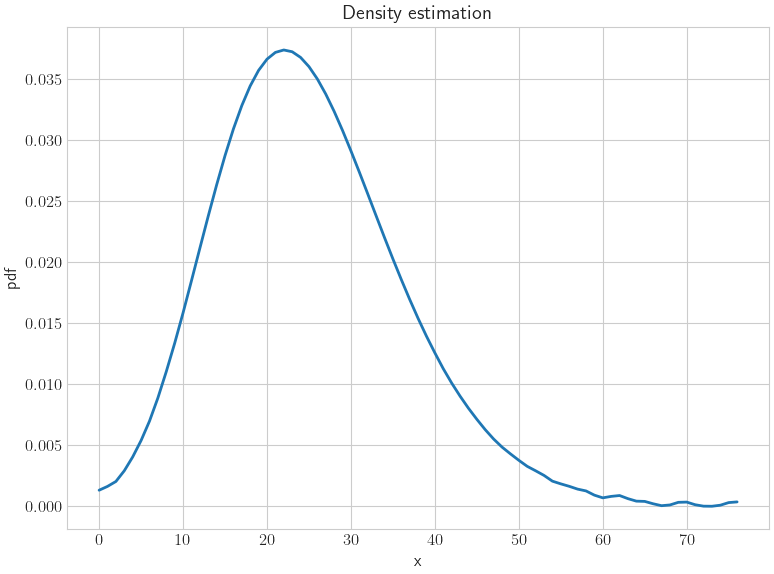

Lower bound of estimation interval (a) is: [0.]
Upper bound of estimation interval (b) is: [75.66290521]
Matrix([[0.00377656126338389]])


In [ ]:
# for this density function: partially discrete (probability of it being 0 is like 1/3, for instance), and partially continuous for any nonzero input

est=OptionEstimator(h=1, n=1024, option='ECO')
#x=np.linspace(0,1,1000)
x=[50]
f=est.density_estimation(x)
print(f[0])

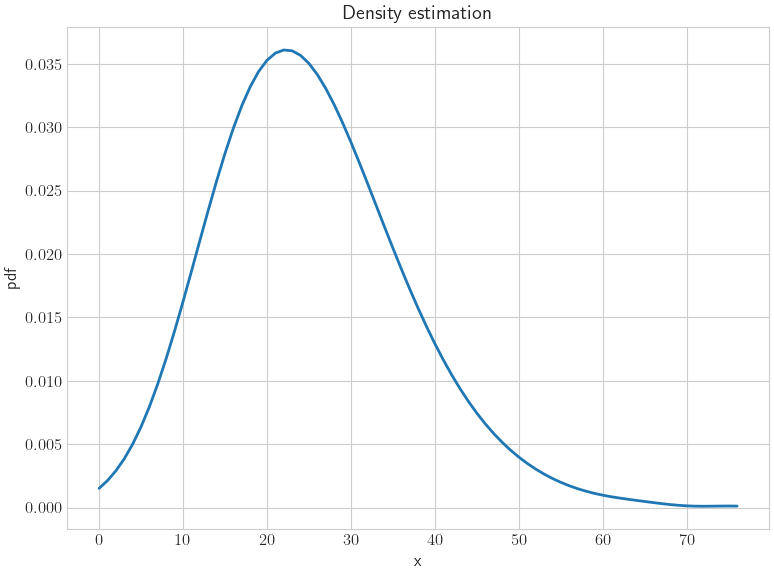

Lower bound of estimation interval (a) is: [0.]
Upper bound of estimation interval (b) is: [75.2365274]
Matrix([[0.00399083767883649]])


In [ ]:
# higher bandwidth = smoother--especially near tails

est=OptionEstimator(h=3, n=1024, option='ECO')
#x=np.linspace(0,1,1000)
x=[50]
f=est.density_estimation(x)
print(f[0])

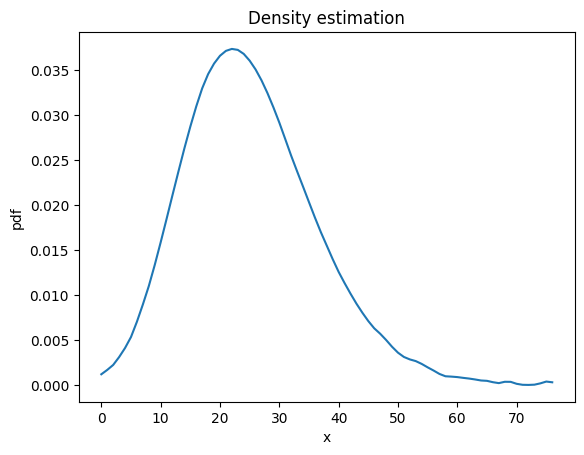

Lower bound of estimation interval (a) is: [0.]
Upper bound of estimation interval (b) is: [75.25926147]
Matrix([[0.00118555840144816], [0.00118617525703258], [0.00118679180928411], [0.00118740805795243], [0.00118802400278882], [0.00118863964354615], [0.00118925497997889], [0.00118987001184309], [0.00119048473889640], [0.00119109916089808], [0.00119171327760896], [0.00119232708879149], [0.00119294059420971], [0.00119355379362926], [0.00119416668681738], [0.00119477927354290], [0.00119539155357627], [0.00119600352668954], [0.00119661519265636], [0.00119722655125197], [0.00119783760225323], [0.00119844834543862], [0.00119905878058820], [0.00119966890748366], [0.00120027872590827], [0.00120088823564695], [0.00120149743648619], [0.00120210632821412], [0.00120271491062046], [0.00120332318349657], [0.00120393114663539], [0.00120453879983151], [0.00120514614288110], [0.00120575317558196], [0.00120635989773353], [0.00120696630913682], [0.00120757240959449], [0.00120817819891081], [0.0012087836

In [ ]:
# # super slow if use linspace(0,1,1000)--basically does it 1000 times? doesn't change anything though
# est=OptionEstimator(h=1, n=1024, option='ECO')
# x=np.linspace(0,1,1000)
# # x=[50]
# f=est.density_estimation(x)
# print(f[0])

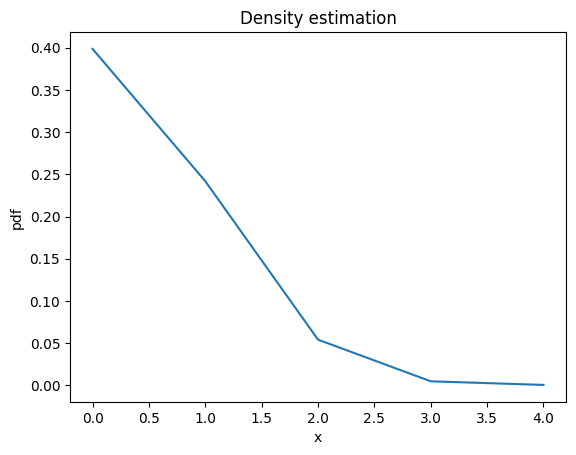

Lower bound of estimation interval (a) is: [0.]
Upper bound of estimation interval (b) is: [3.51272531]
Matrix([[0]])


In [ ]:
est=OptionEstimator(h=1, n=1024, option='EPO')
#x=np.linspace(0,1,1000)
x=[50]
f=est.density_estimation(x) # EPO: looks like a neg-sloping line? narrower estimation interval
print(f[0])

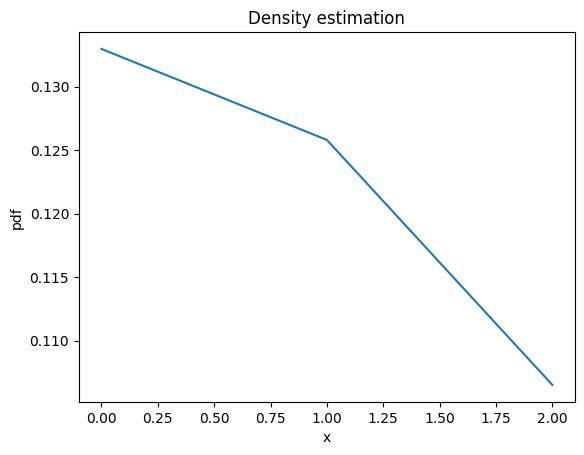

Lower bound of estimation interval (a) is: [0.]
Upper bound of estimation interval (b) is: [1.24317498]
Matrix([[1.20926705084162e-61]])


In [ ]:
## again, more smooth with higher bandwidth

est=OptionEstimator(h=3, n=1024, option='EPO')
#x=np.linspace(0,1,1000)
x=[50]
f=est.density_estimation(x) # EPO: looks like a neg-sloping line? narrower estimation interval
print(f[0])

#### mise?

In [ ]:
ex, mise = est.mise()

TypeError: OptionEstimator.density_estimation() missing 1 required positional argument: 'x'

In [ ]:
est.mise

<bound method OptionEstimator.mise of <__main__.OptionEstimator object at 0x7d5b652ed900>>

In [ ]:
print(est.mise)

<bound method OptionEstimator.mise of <__main__.OptionEstimator object at 0x7d5b652ecfd0>>


#### Asian option

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import qmcpy as qp

In [ ]:
seed = 7

In [ ]:
level=1
aco = qp.AsianOption(qp.Sobol(2*2**level, seed=seed), volatility=.2, start_price=100, strike_price=150, interest_rate=.05, call_put='put')
kde,a,b, approx_solution, data = qp.CubQMCSobolG(aco, abs_tol=1e-4).density_estimation()
print("European Option value: %.5f (to within 1e-4)"% approx_solution)

AttributeError: 'CubQMCSobolG' object has no attribute 'density_estimation'

## Discrepancy

In [ ]:
import qmcpy as qp
from qmcpy import *
import numpy as np
import scipy.stats
import math
#import pandas as pd
import time
#from matplotlib import pyplot
#pyplot.style.use('../qmcpy/qmcpy.mplstyle')
#colors = pyplot.rcParams['axes.prop_cycle'].by_key()['color']
print('ok')

ok


We generated our points in $d$ dimensions and generated $n$ samples such that $\boldsymbol{x}_i \in [0,1]^d$ for $i = 1, 2, 3, ..., n$. Let matrix $\boldsymbol{X}$ be a $n \times d$ matrix such that
$$
\boldsymbol{X} =
\begin{bmatrix}
\boldsymbol{x}_1\\
\boldsymbol{x}_2\\
\boldsymbol{x}_3\\
...\\
\boldsymbol{x}_n\\
\end{bmatrix}
$$
which can be rewritten as
$$
\boldsymbol{X} =
\begin{bmatrix}
\boldsymbol{x}_{1_1} & \boldsymbol{x}_{1_2} & \boldsymbol{x}_{1_3} & ... & \boldsymbol{x}_{1_d}\\
\boldsymbol{x}_{2_1} & \boldsymbol{x}_{2_2} & \boldsymbol{x}_{2_3} & ... & \boldsymbol{x}_{2_d}\\
\boldsymbol{x}_{3_1} & \boldsymbol{x}_{3_2} & \boldsymbol{x}_{3_3} & ... & \boldsymbol{x}_{3_d}\\
... & ... & ... & ... & ...\\
\boldsymbol{x}_{n_1} & \boldsymbol{x}_{n_2} & \boldsymbol{x}_{n_3} & ... & \boldsymbol{x}_{n_d}\\
\end{bmatrix}
$$

We want to find our discrepancy in star discrepancy we must calculate
$$
[D(\boldsymbol{X}) ]^2= \underbrace{\int_{[0,1]^d} \int_{[0,1]^d} K(x,y)~dx~dy}_{A} - \frac{2}{n} \sum_{i=1}^n \underbrace{\int_{[0,1]^d} K(x, \boldsymbol{x}_i) ~dx}_{B(\boldsymbol{x}_i)} + \frac{1}{n^2} \sum_{i,j = 1}^n K(\boldsymbol{x}_i, \boldsymbol{x}_j)
$$
Note, the kernel for star discrepancy is $K(\boldsymbol{x}_i,\boldsymbol{x}_j) = \prod_{k=1}^d [2 - \max(\boldsymbol{x}_{i_k}, \boldsymbol{x}_{j_k})]$. Also, $\int_{[0,1]^d} \int_{[0,1]^d} K(x,y)~dx~dy = (\frac{4}{3})^d$ and $\frac{2}{n} \sum_{i=1}^n \int_{[0,1]^d} K(x, \boldsymbol{x}_i) ~dx = \prod_{k=1}^d (\frac{3 - \boldsymbol{x}_{i_k}^2}{2})$. For the sake of program let,
$$
A = \int_{[0,1]^d} \int_{[0,1]^d} K(x,y)~dx~dy = (\frac{4}{3})^d
$$
$$
B = \frac{2}{n} \sum_{i=1}^n \int_{[0,1]^d} K(x, \boldsymbol{x}_i) ~dx = \prod_{k=1}^d (\frac{3 - \boldsymbol{x}_{i_k}^2}{2})
$$
$$
C = \frac{1}{n^2} \sum_{i,j = 1}^n \prod_{k=1}^d [2 - \max(\boldsymbol{x}_{i_k}, \boldsymbol{x}_{j_k})]
$$
So, $D(\boldsymbol{X}) = \sqrt{A - B + C}$. We calculate

In [ ]:
def star_disc(x):
    n, d = x.shape

    A = (4/3)**d

    b_1 = (3-x**2)/2
    b_2 = b_1.prod(axis=1)
    B = 2*np.mean(b_2)

    c_1 = np.zeros((n,n,d)) + x
    y = np.resize(x, (n, 1, d))
    c_2 = 2 - np.maximum(c_1, y)
    c_3 = c_2.prod(axis=2)
    c_4 = np.mean(c_3)
    C = np.mean(c_4)

    disc = (A - B + C)**.5
    return disc

We want to find our discrepancy in L2star discrepancy. The equation to find the discrepancy is the same except we choose a different equation for the kernel. Which our kernel is $K(x,y) = \prod_{k=1}^d (1 - \max(x_k,y_k))$. And so to get our discrepancy we must calculate
$$
[D(\boldsymbol{X}) ]^2= \int_{[0,1]^d} \int_{[0,1]^d} K(x,y)~dx~dy - \frac{2}{n} \sum_{i=1}^n \int_{[0,1]^d} K(x, \boldsymbol{x}_i) ~dx + \frac{1}{n^2} \sum_{i,j = 1}^n K(\boldsymbol{x}_i, \boldsymbol{x}_j)
$$
$$
[D(\boldsymbol{X}) ]^2= (1/3)^d - \frac{2}{n} \sum_{i=1}^n \prod_{k=1}^d (\frac{1 - \boldsymbol{x}_{i_k}^2}{2}) + \frac{1}{n^2} \sum_{i,j = 1}^n \prod_{k=1}^d (1 - \max(\boldsymbol{x}_{i_k}, \boldsymbol{x}_{j_k}))
$$
$$
D(\boldsymbol{X}) = \sqrt{(1/3)^d - \frac{2}{n} \sum_{i=1}^n \prod_{k=1}^d (\frac{1 - \boldsymbol{x}_{i_k}^2}{2}) + \frac{1}{n^2} \sum_{i,j = 1}^n \prod_{k=1}^d (1 - \max(\boldsymbol{x}_{i_k}, \boldsymbol{x}_{j_k}))}
$$
So now let A, B, and C be calculated as

$$
A = \int_{[0,1]^d} \int_{[0,1]^d} K(x,y)~dx~dy = (\frac{1}{3})^d
$$
$$
B = \frac{2}{n} \sum_{i=1}^n \int_{[0,1]^d} K(x, \boldsymbol{x}_i) ~dx = \prod_{k=1}^d (\frac{1 - \boldsymbol{x}_{i_k}^2}{2})
$$
$$
C = \frac{1}{n^2} \sum_{i,j = 1}^n \prod_{k=1}^d (1 - \max(x_k,y_k))
$$
So, $D(\boldsymbol{X}) = \sqrt{A - B + C}$. We calculate

In [ ]:
def L2star_disc(x):
    n, d = x.shape

    A = (1/3)**d

    b_1 = (1 - x**2)/2
    b_2 = b_1.prod(axis=1)
    B = 2*np.mean(b_2)
    print(B)
    c_1 = np.zeros((n,n,d)) + x
    y = np.resize(x, (n, 1, d))
    c_2 = 1 - np.maximum(c_1, y)
    c_3 = c_2.prod(axis=2)
    c_4 = np.mean(c_3)
    C = np.mean(c_4)

    disc = (A - B + C)**.5
    return disc

We want to find our discrepancy in centered discrepancy. We will choose our kernel to be $K(x,y) = \prod_{k=1}^d (1 + .5|\boldsymbol{x}_k - .5| + .5|\boldsymbol{y}_k - .5| - .5 |\boldsymbol{x}_k - \boldsymbol{y}_k|)$. And so to get our discrepancy we must calculate
$$
[D(\boldsymbol{X}) ]^2= \int_{[0,1]^d} \int_{[0,1]^d} K(x,y)~dx~dy - \frac{2}{n} \sum_{i=1}^n \int_{[0,1]^d} K(x, \boldsymbol{x}_i) ~dx + \frac{1}{n^2} \sum_{i,j = 1}^n K(\boldsymbol{x}_i, \boldsymbol{x}_j)
$$
$$
[D(\boldsymbol{X}) ]^2= (13/12)^d - \frac{2}{n} \sum_{i=1}^n \prod_{k=1}^d (1 + .5|\boldsymbol{x}_{i_k} - .5| - .5 (\boldsymbol{x}_{i_k} -.5)^2) + \frac{1}{n^2} \sum_{i,j = 1}^n \prod_{k=1}^d (1 + .5|\boldsymbol{x}_{i_k} - .5| + .5|\boldsymbol{x}_{j_k} - .5| - .5 |\boldsymbol{x}_{i_k} - \boldsymbol{x}_{j_k}|)
$$
$$
D(\boldsymbol{X}) = \sqrt{(13/12)^d - \frac{2}{n} \sum_{i=1}^n \prod_{k=1}^d (1 + .5|\boldsymbol{x}_{i_k} - .5| - .5 (\boldsymbol{x}_{i_k} -.5)^2) + \frac{1}{n^2} \sum_{i,j = 1}^n \prod_{k=1}^d (1 + .5|\boldsymbol{x}_{i_k} - .5| + .5|\boldsymbol{x}_{j_k} - .5| - .5 |\boldsymbol{x}_{i_k} - \boldsymbol{x}_{j_k}|)}
$$
Let A, B, and C be calculated as

$$
A = \int_{[0,1]^d} \int_{[0,1]^d} K(x,y)~dx~dy = (\frac{13}{12})^d
$$
$$
B = \frac{2}{n} \sum_{i=1}^n \int_{[0,1]^d} K(x, \boldsymbol{x}_i) ~dx = \frac{2}{n} \sum_{i=1}^n \prod_{k=1}^d (1 + .5|\boldsymbol{x}_{i_k} - .5| - .5 (\boldsymbol{x}_{i_k} -.5)^2)
$$
$$
C = \frac{1}{n^2} \sum_{i,j = 1}^n \prod_{k=1}^d (1 + .5|\boldsymbol{x}_{i_k} - .5| + .5|\boldsymbol{x}_{j_k} - .5| - .5 |\boldsymbol{x}_{i_k} - \boldsymbol{x}_{j_k}|)
$$
Of course $D(\boldsymbol{X}) = \sqrt{A - B + C}$. So now we calculate,

In [ ]:
def center_disc(x):
    n, d = x.shape

    A = (13/12)**d

    b_1 = 1 + (.5*abs(x - .5)) - (.5*((x -.5)**2))
    b_2 = b_1.prod(axis=1)
    B = 2*np.mean(b_2)

    c_1 = np.zeros((n,n,d)) + x
    y = np.resize(x, (n, 1, d))
    c_2 = 1 + (.5*abs(c_1 - .5)) + (.5*abs(y - .5)) - (.5*abs(c_1 - y))
    c_3 = c_2.prod(axis=2)
    c_4 = np.mean(c_3)
    C = np.mean(c_4)
    print(C)

    disc = (A - B + C)**.5
    return disc

We want to find our discrepancy in symmetric discrepancy. We will choose our kernel to be $K(x,y) = \prod_{k=1}^d (2 - 2|\boldsymbol{x}_k - \boldsymbol{y}_k|)$. And so to get our discrepancy we must calculate
$$
[D(\boldsymbol{X}) ]^2= \int_{[0,1]^d} \int_{[0,1]^d} K(x,y)~dx~dy - \frac{2}{n} \sum_{i=1}^n \int_{[0,1]^d} K(x, \boldsymbol{x}_i) ~dx + \frac{1}{n^2} \sum_{i,j = 1}^n K(\boldsymbol{x}_i, \boldsymbol{x}_j)
$$
$$
[D(\boldsymbol{X}) ]^2= (4/3)^d - \frac{2}{n} \sum_{i=1}^n \prod_{k=1}^d (1 + 2\boldsymbol{x}_{i_k} - 2 \boldsymbol{x}_{i_k}^2) + \frac{1}{n^2} \sum_{i,j = 1}^n \prod_{k=1}^d (2 - 2|\boldsymbol{x}_{i_k} - \boldsymbol{x}_{j_k}|)
$$
$$
D(\boldsymbol{X}) = \sqrt{(4/3)^d - \frac{2}{n} \sum_{i=1}^n \prod_{k=1}^d (1 + 2\boldsymbol{x}_{i_k} - 2 \boldsymbol{x}_{i_k}^2) + \frac{1}{n^2} \sum_{i,j = 1}^n \prod_{k=1}^d (2 - 2|\boldsymbol{x}_{i_k} - \boldsymbol{x}_{j_k}|)}
$$
Let A, B, and C be calculated as

$$
A = \int_{[0,1]^d} \int_{[0,1]^d} K(x,y)~dx~dy = (\frac{4}{3})^d
$$
$$
B = \frac{2}{n} \sum_{i=1}^n \int_{[0,1]^d} K(x, \boldsymbol{x}_i) ~dx = \frac{2}{n} \sum_{i=1}^n \prod_{k=1}^d (1 + 2\boldsymbol{x}_{i_k} - 2 \boldsymbol{x}_{i_k}^2)
$$
$$
C = \frac{1}{n^2} \sum_{i,j = 1}^n \prod_{k=1}^d (2 - 2|\boldsymbol{x}_{i_k} - \boldsymbol{x}_{j_k}|)
$$
Of course $D(\boldsymbol{X}) = \sqrt{A - B + C}$. So now we calculate,

In [ ]:
def symmetric_disc(x):
    n, d = x.shape

    A = (4/3)**d

    b_1 = 1 + 2*x - (2*(x**2))
    b_2 = b_1.prod(axis=1)
    B = 2*np.mean(b_2)

    c_1 = np.zeros((n,n,d)) + x
    y = np.resize(x, (n, 1, d))
    c_2 = 2 - (2*abs(c_1 - y))
    c_3 = c_2.prod(axis=2)
    c_4 = np.mean(c_3)
    C = np.mean(c_4)

    disc = (A - B + C)**.5
    return disc

Now we want to do our wrap around discrepancy. Of course, to calculate it we have
$$
D(\boldsymbol{X}) = \sqrt{ -(4/3)^d + \frac{1}{n^2} \sum_{i,j = 1}^n \prod_{k=1}^d (\frac{3}{2} - |\boldsymbol{x}_{i_k} - \boldsymbol{x}_{j_k}|(1 - |\boldsymbol{x}_{i_k} - \boldsymbol{x}_{j_k}|))}
$$
Since there are only 2 parts, let
$$
A = -(\frac{4}{3})^d
$$
$$
B = \frac{1}{n^2} \sum_{i,j = 1}^n \prod_{k=1}^d (\frac{3}{2} - |\boldsymbol{x}_{i_k} - \boldsymbol{x}_{j_k}|(1 - |\boldsymbol{x}_{i_k} - \boldsymbol{x}_{j_k}|))
$$
So the equation becomes $D(\boldsymbol{X}) = \sqrt{A+B}$. We calculate

In [ ]:
def wrap_around_disc(x):
    n, d = x.shape

    A = -(4/3)**d

    b_1 = np.zeros((n,n,d)) + x
    y = np.resize(x, (n, 1, d))
    b_2 = 1.5 - (abs(b_1 - y)*(1 - abs(b_1 - y)))
    b_3 = b_2.prod(axis=2)
    b_4 = np.mean(b_3)
    B = np.mean(b_4)

    disc = (A + B)**.5
    return disc

This and next cell are play cells. So the L2-star discrepancy works just as accurately as the scipy discrepancy; however, confused on the centered discrepancy because in my code I square root to get $D(\boldsymbol{X})$. However in scipy that doesn't seem to be the case. To prove it. I printed out the following outputs. So for the centered discrepancy, this would mean that either I was not suppose to square root or scipy forgot to square root.

In [ ]:
A = qp.IIDStdUniform(dimension=3)
X = A.gen_samples(n=1024)
print("L2-star")
print(L2star_disc(X))
print(scipy.stats.qmc.discrepancy(X, method='L2-star'))
print("centered")
print(center_disc(X))
print(scipy.stats.qmc.discrepancy(X, method='CD'))
print(scipy.stats.qmc.discrepancy(X, method='CD')**.5)
print("wrap around")
print(wrap_around_disc(X))
print(scipy.stats.qmc.discrepancy(X, method='WD'))
print(scipy.stats.qmc.discrepancy(X, method='WD')**.5)

L2-star
0.07693131636466943
0.010104910500218296
0.010104910500217952
centered
1.271574215249667
0.029037318712690333
0.0008431658779100015
0.029037318710755673
wrap around
0.027730241796826708
0.0007689663101593247
0.02773024179770751


In [ ]:
A = qp.IIDStdUniform(dimension=3)
X = A.gen_samples(n=1024)
star_disc(X)
limiter = 1024
n, d = X.shape  #initialize the list as empty

X_expanded = np.resize(X, (1, n, d))
Y = np.resize(X, (n, 1, d))
iterated_X = []
iterated_X_expanded = []
iterated_Y = []

for i_1 in range(int(n/limiter)+1):               #These 4 lines are used to make these lists into chunks
    iterated_X = iterated_X + [X[i_1*limiter: (i_1+1)*limiter, :]]
    iterated_X_expanded = iterated_X_expanded + [X_expanded[:, i_1*limiter: (i_1+1)*limiter, :]]
    iterated_Y = iterated_Y + [Y[i_1*limiter: (i_1+1)*limiter, :, :]]


if n%limiter == 0:
    iterated_X = iterated_X[0: len(iterated_X) - 1]
    iterated_X_expanded = iterated_X_expanded[0:len(iterated_X_expanded)-1]
    iterated_Y = iterated_Y[0:len(iterated_Y)-1]

DI = (1 + (weight/3)).prod(axis=0)

B = 0
for j in range(len(iterated_X)):
    x = iterated_X[j]
    single_integral = ((1 + (weight*(1 - x**2)/2))).prod(axis=1)
    B = B + np.sum(single_integral)

SI = B*2/n

C = 0
for j in range(len(iterated_X_expanded)):
    for i in range(len(iterated_Y)):
        x = iterated_X_expanded[j]
        y = iterated_Y[i]
        kernel = (1 + weight*(1 - np.maximum(X_expanded, Y))).prod(axis=2)
        C = C + np.sum(np.sum(kernel))

K = C/(n**2)

NameError: name 'weight' is not defined

In [ ]:
A = qp.IIDStdUniform(dimension=3)
X = A.gen_samples(n=1024)
print(qp.discrepancy2('l2star', X, limiter = 2**22, Time = True))
star_disc(X)

AttributeError: module 'qmcpy' has no attribute 'discrepancy2'